In [1]:
import pandas as pd

In [2]:
from sqlalchemy import create_engine, text

In [3]:
import sys

# os.chdir('C:/Users/user/Documents/hs/pipeline-main/pipeline-main/')

sys.path.append('../py')

import data_processing as proc
import utils
import performance as perf


2024-04-03 11:08:33.481938: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 11:08:33.537372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import cx_Oracle
import os
os.putenv(' NLS_LANG', '.UTF8')

In [5]:
dsn = cx_Oracle.makedsn('192.168.1.5', '1521', service_name = 'ORA11')
con = cx_Oracle.connect('dbam', 'dbamkass', dsn = dsn, encoding="UTF-8")
cur = con.cursor()

In [6]:
sql_k200 = " select 일자, 종목코드2 종목코드, 종목명_국문 종목명, 당일가격, 지수내비중, 상장주식수, 유동비율, \
            지수주식수, 지수시가총액 \
             from KASS1.TH068 \
             where 익일적용여부 ='NXT' \
             and ISIN = 'KRD020020016' \
             order by 지수내비중 desc "

cur.execute(sql_k200)
k200_df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])



In [7]:
k200_df['일자']=pd.to_datetime(k200_df['일자'], format ='%Y%m%d')
k200_df.set_index(['일자', '종목코드'], inplace=True)
k200_df.index.names=['Dates', 'Symbol']
k200_df.columns=['name', 'close', 'idx_weight', 'num_shares', 'float_rate', 'idx_num_shares', 'idx_cap']


In [8]:
k200_df=k200_df.sort_index(level='Dates')

In [9]:
host = '192.168.1.27'
port = '3306'
db_name = 'quantdb_maria'
username = 'quantdb'
password = 'QuantDb2023!'

engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + ":" + port + "/" + db_name)
conn=engine.connect()

In [10]:
period1='2014-09-01'
period2='2024-03-29'

In [11]:
query_COM=f"select * from COM_Table where Dates>='{period1}' and Dates<='{period2}'"
data_COM=pd.read_sql(query_COM, conn)

In [12]:
data_COM.set_index(['Dates','Symbol'], inplace=True)

In [13]:
data_COM_nodup=data_COM.loc[~data_COM.index.duplicated(keep='last')].copy()

In [14]:
query_SSC=f"select * from SSC_table_Bak where Dates>='{period1}' and Dates<='{period2}'"
data_SSC=pd.read_sql(query_SSC, conn)

In [15]:
data_SSC.set_index(['Dates','Symbol'], inplace=True)

In [16]:
data_SSC_nodup=data_SSC.loc[~data_SSC.index.duplicated(keep='last')].copy()

In [17]:
data_SSC.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [18]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [19]:
query_idx=f"select * from krx_idx"
krx_idx=pd.read_sql(query_idx, conn)

In [20]:
krx_idx.set_index('Dates', inplace=True)


<Axes: xlabel='Dates'>

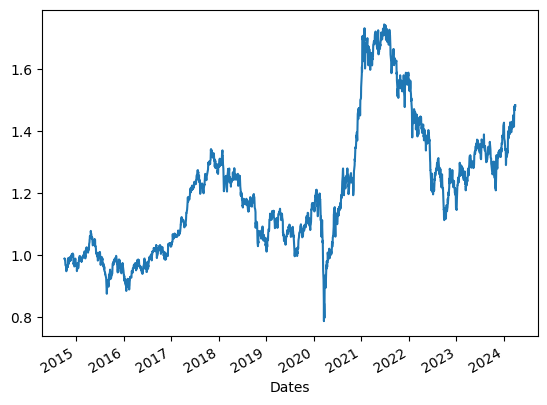

In [21]:
(1+krx_idx['코스피 200'].pct_change().loc['2014-10-02':]).cumprod().plot()

# backtesting

In [22]:
adjprc=data_SSC_nodup['AdjPrc'].unstack()
adjprc=adjprc.astype(float)

In [23]:
data_path='../data/output/prob_out/'
# file_name='multilayer_factor_rolling_v1.0_2022-12-29.csv'
# file_name='prob_res_2013-01-25_2023-08-31.csv'
# file_name='multilayer_factor_rolling_v1.0_2024-01-31.csv'
# file_name='multilayer_factor_rolling_v1.0_2024-01-31ver0.1.csv'
file_name='prob_out_2017-2024.03.csv'
# hyungshin.lee/data/output/prob_out/prob_res_2013-01-25_2023-08-31.csv
raw_prob=pd.read_csv(data_path+file_name, index_col=0)

# mlq_w=pd.read_excel(data_path + 'monthly_port.xlsx', index_col=0)

In [24]:
raw_prob

,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A175330,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-10,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-17,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,0.197560,0.212692,0.198181,0.218659,0.200264,0.199464,0.174447,0.209748,0.208342,0.171266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-08,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-16,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537


In [25]:
# raw_prob.reset_index(inplace=True)
# raw_prob.set_index(['Dates', 'Symbol'], inplace=True)
# raw_prob=raw_prob.unstack()
# raw_prob.columns=raw_prob.columns.get_level_values(1)

In [26]:
raw_prob

,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A175330,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-10,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-17,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,0.197560,0.212692,0.198181,0.218659,0.200264,0.199464,0.174447,0.209748,0.208342,0.171266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-08,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-16,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537


In [27]:
raw_prob.index = pd.to_datetime(raw_prob.index)

<Axes: xlabel='Dates'>

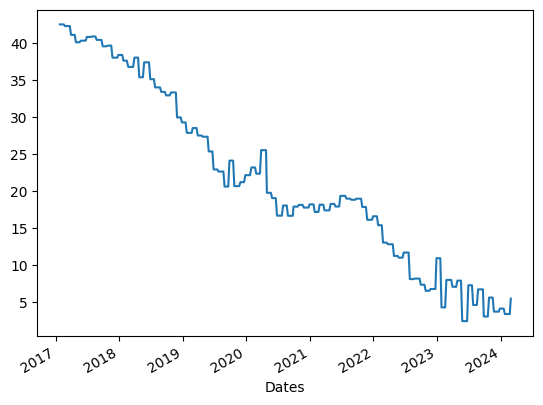

In [28]:
raw_prob.sum(1).plot()

<Axes: xlabel='Dates'>

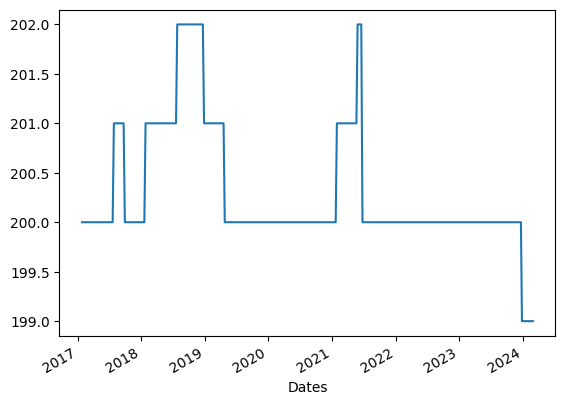

In [29]:
raw_prob.count(1).plot()

In [30]:
raw_prob

,A000030,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000210,A000230,...,A175330,A139130,A001570,A005420,A008730,A002710,A006110,A009970,A145720,A267260
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-10,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-17,0.196514,0.213207,0.201616,0.221707,0.205032,0.203640,0.180936,0.212850,0.206762,0.166823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,0.197560,0.212692,0.198181,0.218659,0.200264,0.199464,0.174447,0.209748,0.208342,0.171266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-08,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537
2024-02-16,NaN,NaN,NaN,0.015173,0.017888,0.010509,NaN,0.014826,0.014767,NaN,...,0.019972,0.019446,0.010970,0.017091,0.019727,0.005210,0.010607,0.018838,0.018438,0.012537


<Axes: xlabel='Dates'>

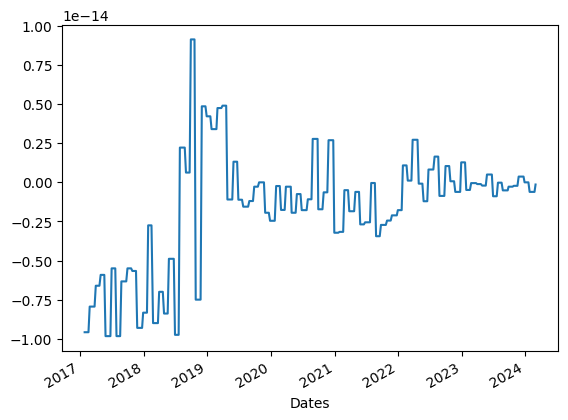

In [31]:
raw_prob.subtract(raw_prob.mean(1), axis=0).sum(1).plot()

In [32]:
# use existing weight with shift1

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [34]:
scaler = StandardScaler()
tempw = scaler.fit_transform(raw_prob.iloc[0].dropna().values.reshape(-1, 1))
temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[0].dropna().index)

In [35]:
temp_w=temp_w/abs(temp_w).sum()

In [36]:
temp_w

,0
A000030,-0.008138
A000050,0.000163
A000070,-0.005601
A000080,0.004389
A000100,-0.003902
...,...
A170900,0.008757
A185750,0.003835
A192400,-0.004988
A192820,0.002943


In [292]:
raw_prob.iloc[-1].sort_values().dropna()

A000880    0.006596
A005930    0.009495
A139480    0.009790
A036460    0.011444
A001120    0.012125
             ...   
A039490    0.040236
A010620    0.040862
A383220    0.044656
A003410    0.049155
A003620    0.340030
Name: 2024-02-29 00:00:00, Length: 199, dtype: float64

In [308]:
ls_weight_ls = []
len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob.iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob.iloc[i].dropna().index)
    
    # remove top bottom +/- 2stdev
    temp_w[temp_w>(temp_w.mean()+2*temp_w.std())]=2
    temp_w[temp_w<(temp_w.mean()-2*temp_w.std())]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w=temp_w/abs(temp_w).sum()
    len_ls.append(len(temp_w[temp_w>0].dropna()))
    ls_weight_ls.append(temp_w)
    

<Axes: >

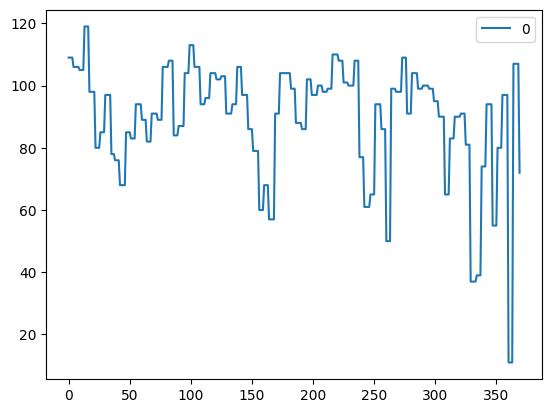

In [309]:
pd.DataFrame(len_ls).plot()

In [310]:
ls_w=pd.concat(ls_weight_ls, axis=1).T
ls_w.index=raw_prob.index

<Axes: >

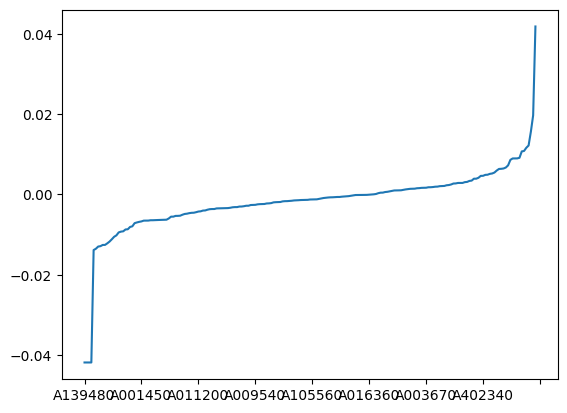

In [311]:
ls_w.iloc[-1].sort_values().dropna().plot()

In [312]:
temp_ls_w=ls_w.copy()
temp_ls_w.loc[:, 'A001570']=0

In [313]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_2982978/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [314]:
idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)

/tmp/ipykernel_2982978/3876697821.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*temp_ls_w.shift(1)


In [315]:
long_w=ls_w[temp_ls_w>0]
short_w=ls_w[temp_ls_w<0]


In [316]:
ew_long=long_w.copy()
ew_short=short_w.copy()

In [317]:
ew_long[ew_long>0]=1
ew_short[ew_short<0]=-1

In [318]:
ew_long=ew_long.div(ew_long.count(1), axis=0)
ew_short=ew_short.div(ew_short.count(1), axis=0)

<Axes: xlabel='Dates'>

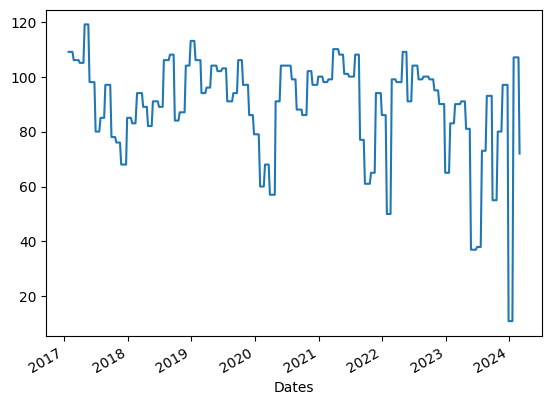

In [319]:
ew_long.count(1).plot()

In [320]:
long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2

/tmp/ipykernel_2982978/425279764.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*long_w.shift(1)*2
/tmp/ipykernel_2982978/425279764.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*short_w.shift(1)*2


In [321]:
ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)

/tmp/ipykernel_2982978/4102127311.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_long_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_long.shift(1)
/tmp/ipykernel_2982978/4102127311.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ew_short_idx_ret=adjprc.loc[ls_w.index, ls_w.columns].pct_change()*ew_short.shift(1)


# LS results

In [322]:
long_w.loc['2023-06-01': '2023-12-01', 'A001570'].fillna(0)

Dates
2023-06-02    0.0
2023-06-09    0.0
2023-06-16    0.0
2023-06-23    0.0
2023-06-30    0.0
2023-07-07    0.0
2023-07-14    0.0
2023-07-21    0.0
2023-07-28    0.0
2023-08-04    0.0
2023-08-11    0.0
2023-08-18    0.0
2023-08-25    0.0
2023-09-01    0.0
2023-09-08    0.0
2023-09-15    0.0
2023-09-22    0.0
2023-09-27    0.0
2023-10-06    0.0
2023-10-13    0.0
2023-10-20    0.0
2023-10-27    0.0
2023-11-03    0.0
2023-11-10    0.0
2023-11-17    0.0
2023-11-24    0.0
2023-12-01    0.0
Name: A001570, dtype: float64

/tmp/ipykernel_2982978/1600025215.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()


<Axes: xlabel='Dates'>

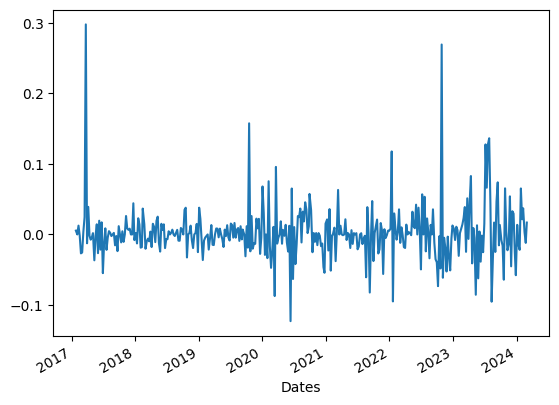

In [323]:
adjprc.pct_change().loc[ls_w.index, 'A001570'].plot()

In [324]:
ls_w.loc['2023-06-01':].index

DatetimeIndex(['2023-06-02', '2023-06-09', '2023-06-16', '2023-06-23',
               '2023-06-30', '2023-07-07', '2023-07-14', '2023-07-21',
               '2023-07-28', '2023-08-04', '2023-08-11', '2023-08-18',
               '2023-08-25', '2023-09-01', '2023-09-08', '2023-09-15',
               '2023-09-22', '2023-09-27', '2023-10-06', '2023-10-13',
               '2023-10-20', '2023-10-27', '2023-11-03', '2023-11-10',
               '2023-11-17', '2023-11-24', '2023-12-01', '2023-12-08',
               '2023-12-15', '2023-12-22', '2023-12-28', '2024-01-05',
               '2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02',
               '2024-02-08', '2024-02-16', '2024-02-23', '2024-02-29'],
              dtype='datetime64[ns]', name='Dates', freq=None)

In [325]:
adjprc.loc[ls_w.loc['2023-06-01':].index, 'A001570'].pct_change()

Dates
2023-06-02         NaN
2023-06-09    0.132231
2023-06-16    0.100365
2023-06-23   -0.036484
2023-06-30   -0.086059
2023-07-07    0.563089
2023-07-14    0.220482
2023-07-21    0.208292
2023-07-28    0.095588
2023-08-04    0.158837
2023-08-11   -0.164093
2023-08-18   -0.016166
2023-08-25   -0.010172
2023-09-01   -0.005534
2023-09-08    0.082671
2023-09-15   -0.050661
2023-09-22   -0.013921
2023-09-27   -0.056471
2023-10-06   -0.084788
2023-10-13    0.062670
2023-10-20   -0.115385
2023-10-27   -0.118841
2023-11-03    0.009868
2023-11-10    0.090119
2023-11-17   -0.023904
2023-11-24    0.074490
2023-12-01    0.163343
2023-12-08   -0.053061
2023-12-15   -0.008621
2023-12-22   -0.052174
2023-12-28    0.001835
2024-01-05   -0.045788
2024-01-12   -0.043186
2024-01-19   -0.099298
2024-01-26   -0.109131
2024-02-02    0.007500
2024-02-08    0.040943
2024-02-16    0.133492
2024-02-23   -0.044164
2024-02-29    0.061606
Name: A001570, dtype: float64

In [326]:
idx_ret['A001570'].dropna()

Dates
2017-02-03   -0.0
2017-02-10   -0.0
2017-02-17    0.0
2017-02-24   -0.0
2017-03-03   -0.0
             ... 
2024-02-02    0.0
2024-02-08    0.0
2024-02-16    0.0
2024-02-23   -0.0
2024-02-29    0.0
Name: A001570, Length: 369, dtype: float64

<Axes: xlabel='Dates'>

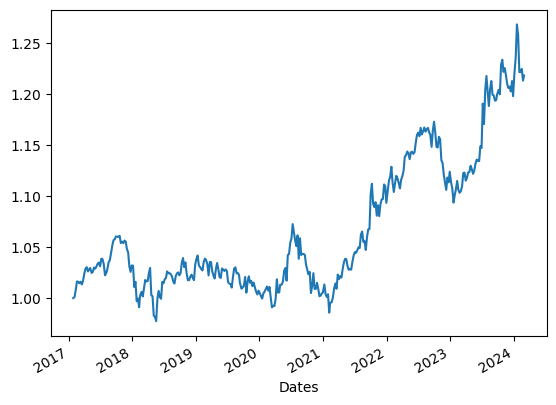

In [327]:
# raw long short 
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

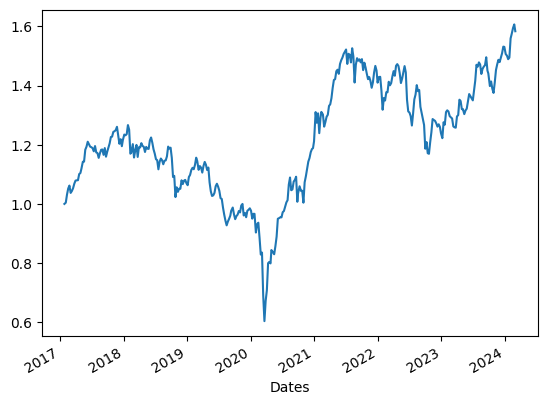

In [328]:
# raw long
(1+long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

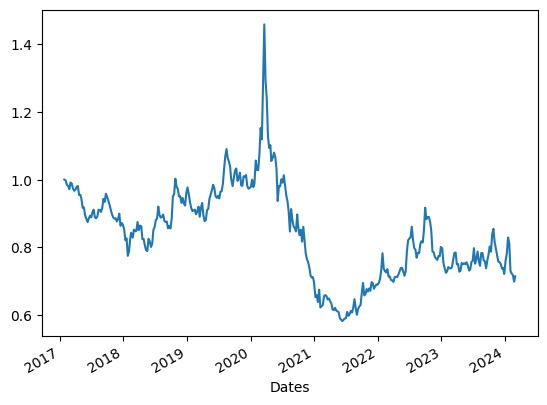

In [329]:
# raw short
(1+short_idx_ret.sum(1)).cumprod().plot()

In [330]:
# equal weight long short

<Axes: xlabel='Dates'>

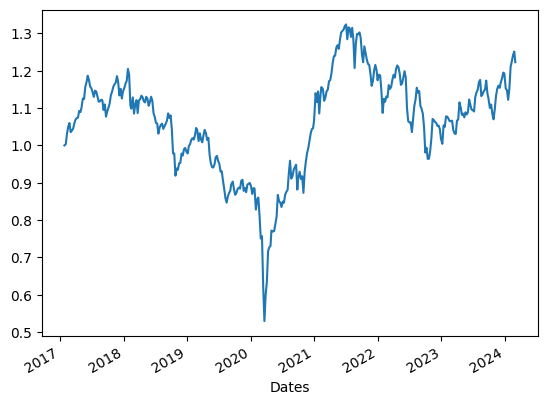

In [331]:
(1+ew_long_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

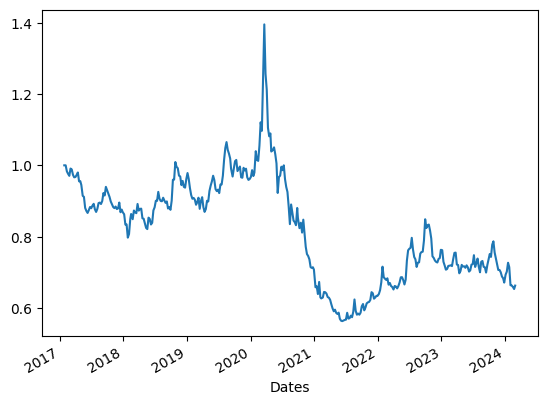

In [332]:
(1+ew_short_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

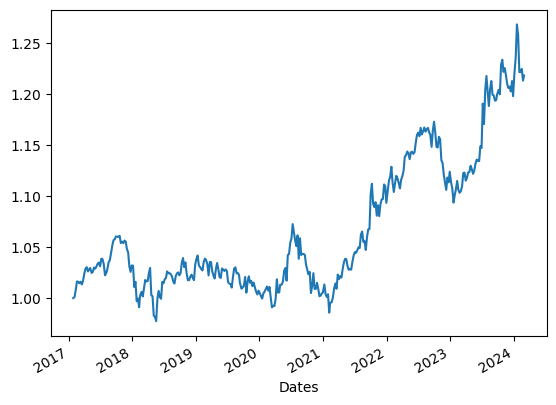

In [333]:
# remove top and bottom
(1+idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

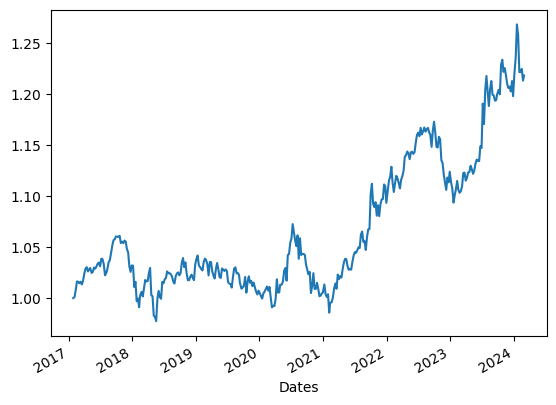

In [334]:
# remove in the middle
(1+idx_ret.sum(1)).cumprod().plot()

In [ ]:
k100ls_entire = perf.analyze_performance(idx_ret.sum(1),
                                     weights = daily_weight,
                                     model_name = 'k100ls')

# k100 universe result

In [335]:
data_COM.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [336]:
k100comp=data_COM_nodup['KOSPI100YN'].to_frame().unstack()

In [337]:
k100comp=k100comp[k100comp=='Y']

In [338]:
k100comp.count(1)

Dates
2014-09-01    100
2014-09-02    100
2014-09-03    100
2014-09-04    100
2014-09-05    100
             ... 
2024-03-25    100
2024-03-26    100
2024-03-27    100
2024-03-28    100
2024-03-29    100
Length: 2356, dtype: int64

In [339]:
k100comp[k100comp=='Y']=1

In [340]:
k100comp.sum(1)

Dates
2014-09-01    100
2014-09-02    100
2014-09-03    100
2014-09-04    100
2014-09-05    100
             ... 
2024-03-25    100
2024-03-26    100
2024-03-27    100
2024-03-28    100
2024-03-29    100
Length: 2356, dtype: object

In [341]:
k100comp=k100comp[k100comp>0].dropna(how='all', axis=1)

In [342]:
k100comp.columns=k100comp.columns.get_level_values(1)

In [343]:
k100comp.columns

Index(['A000030', 'A000080', 'A000100', 'A000120', 'A000150', 'A000210',
       'A000270', 'A000660', 'A000670', 'A000720',
       ...
       'A323410', 'A326030', 'A329180', 'A352820', 'A361610', 'A373220',
       'A377300', 'A383220', 'A402340', 'A450080'],
      dtype='object', name='Symbol', length=149)

In [344]:
k100_col=set(raw_prob.columns).intersection(k100comp.columns)

In [345]:
k100_col=list(k100_col)

In [390]:
k100_ls_weight_ls = []
k100_len_ls = []
for i in range(len(raw_prob.index)):
    scaler = StandardScaler()
    tempw = scaler.fit_transform(raw_prob[k100_col].iloc[i].dropna().values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = raw_prob[k100_col].iloc[i].dropna().index)

    temp_w2=temp_w.copy()
    temp_w2.loc['A001570']=0

    # remove top bottom +/- 2stdev
    temp_w[temp_w>temp_w.mean()+2*temp_w.std()]=2
    temp_w[temp_w<temp_w.mean()-2*temp_w.std()]=-2

    # remove in the middle
    # temp_w[(temp_w<temp_w.mean()+temp_w.std()) & (temp_w>temp_w.mean()-temp_w.std())]=0
    
    temp_w2=temp_w2/abs(temp_w2).sum()
    k100_len_ls.append(len(temp_w2[temp_w2>0].dropna()))
    k100_ls_weight_ls.append(temp_w2)

In [391]:
k100_ls_w=pd.concat(k100_ls_weight_ls, axis=1).T
k100_ls_w.index=raw_prob.index

In [392]:
k100_ls_w.sum(1)[k100_ls_w.sum(1)<-0.05]

Dates
2023-06-30   -0.420059
2023-07-07   -0.420059
2023-07-14   -0.420059
2023-07-21   -0.420059
2023-07-28   -0.062377
2023-08-04   -0.062377
2023-08-11   -0.062377
2023-08-18   -0.062377
dtype: float64

In [393]:
k100_ls_w=k100_ls_w.subtract(k100_ls_w.mean(1), axis=0)

In [394]:
k100_ls_w[k100_ls_w>0]=k100_ls_w[k100_ls_w>0].div(k100_ls_w[k100_ls_w>0].sum(1)*2, axis=0)
k100_ls_w[k100_ls_w<0]=k100_ls_w[k100_ls_w<0].div(k100_ls_w[k100_ls_w<0].sum(1)*-2, axis=0)

<Axes: >

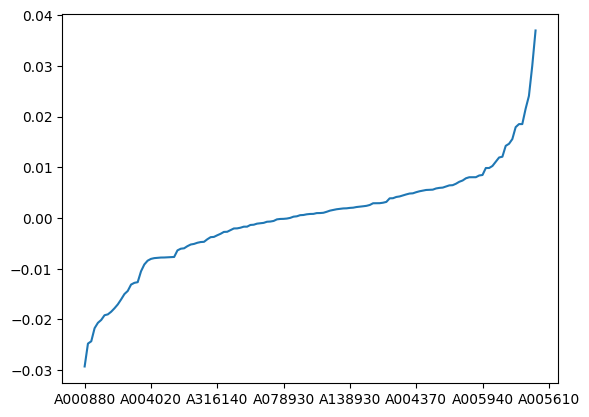

In [395]:
k100_ls_w.iloc[-1].sort_values().plot()

In [396]:
k100_idx_ret=adjprc.loc[k100_ls_w.index, k100_ls_w.columns].pct_change()*k100_ls_w.shift(1)

/tmp/ipykernel_2982978/2815482060.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  k100_idx_ret=adjprc.loc[k100_ls_w.index, k100_ls_w.columns].pct_change()*k100_ls_w.shift(1)


In [397]:
k100_ls_w

,A004000,A004170,A016360,A096770,A005830,A010140,A003490,A030000,A139480,A051900,...,A361610,A259960,A323410,A377300,A402340,A329180,A138040,A373220,A137310,A383220
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.006575,0.003194,-0.003363,0.006822,-0.002095,0.005531,-0.000076,0.002829,0.003390,-0.019095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-03,0.006575,0.003194,-0.003363,0.006822,-0.002095,0.005531,-0.000076,0.002829,0.003390,-0.019095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-10,0.006575,0.003194,-0.003363,0.006822,-0.002095,0.005531,-0.000076,0.002829,0.003390,-0.019095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-17,0.006575,0.003194,-0.003363,0.006822,-0.002095,0.005531,-0.000076,0.002829,0.003390,-0.019095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,0.003466,-0.000097,-0.004102,0.015862,-0.005687,0.002153,-0.000797,0.003274,0.011572,-0.011973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,0.009281,0.000610,0.009478,-0.008433,0.001081,-0.004260,0.001054,0.004386,-0.023624,0.008175,...,0.001951,0.002739,0.005959,0.011749,-0.006236,-0.001047,0.006159,0.00327,0.013158,0.020269
2024-02-08,0.009281,0.000610,0.009478,-0.008433,0.001081,-0.004260,0.001054,0.004386,-0.023624,0.008175,...,0.001951,0.002739,0.005959,0.011749,-0.006236,-0.001047,0.006159,0.00327,0.013158,0.020269
2024-02-16,0.009281,0.000610,0.009478,-0.008433,0.001081,-0.004260,0.001054,0.004386,-0.023624,0.008175,...,0.001951,0.002739,0.005959,0.011749,-0.006236,-0.001047,0.006159,0.00327,0.013158,0.020269


In [398]:
rebal_dates = proc.find_entire_rebalancing_dates(k100_ls_w.index)


lack of the beginning part of data  2016-12-31 00:00:00 2017-01-26 00:00:00
expected date is not in inner dates 2017-01-31 00:00:00
2017-01-31 00:00:00 2017-01-26 00:00:00
expected date is not in inner dates 2017-02-28 00:00:00
2017-02-28 00:00:00 2017-02-24 00:00:00
expected date is not in inner dates 2017-04-30 00:00:00
2017-04-30 00:00:00 2017-04-28 00:00:00
expected date is not in inner dates 2017-05-31 00:00:00
2017-05-31 00:00:00 2017-05-26 00:00:00
expected date is not in inner dates 2017-07-31 00:00:00
2017-07-31 00:00:00 2017-07-28 00:00:00
expected date is not in inner dates 2017-08-31 00:00:00
2017-08-31 00:00:00 2017-08-25 00:00:00
expected date is not in inner dates 2017-09-30 00:00:00
2017-09-30 00:00:00 2017-09-29 00:00:00
expected date is not in inner dates 2017-10-31 00:00:00
2017-10-31 00:00:00 2017-10-27 00:00:00
expected date is not in inner dates 2017-11-30 00:00:00
2017-11-30 00:00:00 2017-11-24 00:00:00
expected date is not in inner dates 2017-12-31 00:00:00
2017

In [399]:
rebal_dates

DatetimeIndex(['2017-01-26', '2017-02-24', '2017-03-31', '2017-04-28',
               '2017-05-26', '2017-06-30', '2017-07-28', '2017-08-25',
               '2017-09-29', '2017-10-27', '2017-11-24', '2017-12-28',
               '2018-01-26', '2018-02-23', '2018-03-30', '2018-04-27',
               '2018-05-25', '2018-06-29', '2018-07-27', '2018-08-31',
               '2018-09-28', '2018-10-26', '2018-11-30', '2018-12-28',
               '2019-01-25', '2019-02-28', '2019-03-29', '2019-04-26',
               '2019-05-31', '2019-06-28', '2019-07-26', '2019-08-30',
               '2019-09-27', '2019-10-25', '2019-11-29', '2019-12-27',
               '2020-01-31', '2020-02-28', '2020-03-27', '2020-04-29',
               '2020-05-29', '2020-06-26', '2020-07-31', '2020-08-28',
               '2020-09-29', '2020-10-30', '2020-11-27', '2020-12-30',
               '2021-01-29', '2021-02-26', '2021-03-26', '2021-04-30',
               '2021-05-28', '2021-06-25', '2021-07-30', '2021-08-27',
      

In [400]:
daily_ret_cost=perf.compute_daily_ret(adjprc, k100_ls_w, rebal_dates)

/home/hyungshin.lee/post analysis/../py/performance.py:289: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_ret=nav.pct_change()


<Axes: xlabel='Dates'>

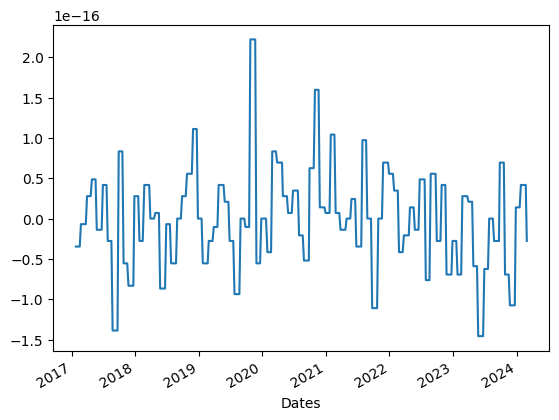

In [401]:
k100_ls_w.fillna(0).sum(1).plot()

In [402]:
init_value=10**9
cost=0.002
daily_quantity=pd.DataFrame(None, index=adjprc.loc[rebal_dates[0]:rebal_dates[-1]].index, columns=k100_ls_w.columns)
temp_price=adjprc.loc[rebal_dates[0]:rebal_dates[-1], k100_ls_w.columns].copy()
rebal_weights=k100_ls_w.fillna(0).copy()
ret_ls=[]

ls_port=(rebal_weights.iloc[0]<0).sum()>0

for idx, date in enumerate(rebal_dates):
    if date == rebal_dates[0]:
        daily_quantity.loc[date]=init_value*rebal_weights.loc[date]/temp_price.loc[date]
        
    else:
        prev_idx=temp_price.index.get_loc(date)-1
        prev_date=temp_price.index[prev_idx]
                
        # fill monthly quantity
        daily_quantity.loc[:prev_date]=daily_quantity.loc[:prev_date].ffill()
        
        # find eom nav
        # for long short portfolio
        # prev date on quantity has an effect of shift(1)
        if ls_port:
            mid_value=(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum() \
                      - (daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()
        else:
            mid_value=(daily_quantity.loc[prev_date]*temp_price.loc[date]).sum()
        
        # find quantity
        daily_quantity.loc[date]=mid_value*rebal_weights.loc[date]/temp_price.loc[date]
    # print(date, mid_value)
    
if ls_port:
    nav1=(daily_quantity[daily_quantity>0]*temp_price).sum(1)
    nav2=(daily_quantity[daily_quantity<0]*temp_price).sum(1)
    daily_ret=nav1.pct_change()-nav2.pct_change()
else:
    nav=daily_quantity*temp_price
    daily_ret=nav.pct_change()

# apply cost
w_diff = abs(rebal_weights.diff(1))
daily_ret.loc[w_diff.index] = daily_ret.loc[w_diff.index] - w_diff.sum(axis=1) * cost

In [403]:
k100_ls_w.index

DatetimeIndex(['2017-01-26', '2017-02-03', '2017-02-10', '2017-02-17',
               '2017-02-24', '2017-03-03', '2017-03-10', '2017-03-17',
               '2017-03-24', '2017-03-31',
               ...
               '2023-12-28', '2024-01-05', '2024-01-12', '2024-01-19',
               '2024-01-26', '2024-02-02', '2024-02-08', '2024-02-16',
               '2024-02-23', '2024-02-29'],
              dtype='datetime64[ns]', name='Dates', length=370, freq=None)

In [404]:
check_date='2017-02-10'
check_nav=daily_quantity.loc[check_date]*temp_price.loc[check_date]
check_nav1=check_nav[check_nav>0]
check_nav2=check_nav[check_nav<0]

In [405]:
check_nav1.sum()-check_nav2.sum()

1014021386.3283213

In [406]:
check_nav=(daily_quantity*temp_price)
check_nav1=check_nav[check_nav>0]
check_nav2=check_nav[check_nav<0]

<Axes: xlabel='Dates'>

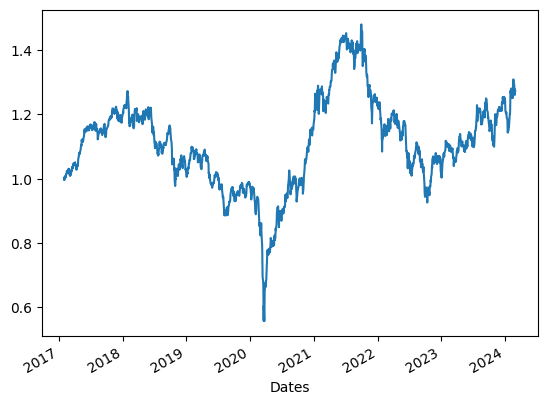

In [407]:
(1+(check_nav1.sum(1)-check_nav2.sum(1)).pct_change()).cumprod().plot()

In [408]:
check_nav3=check_nav1.sum(1)-check_nav2.sum(1)


In [365]:
check_nav1.pct_change().loc['2023-06-30'].sort_values()

/tmp/ipykernel_2982978/1252267684.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  check_nav1.pct_change().loc['2023-06-30'].sort_values()


A271560   -8.701396e-01
A032830   -8.646653e-01
A010140   -8.631913e-01
A003550   -8.261910e-01
A066570   -7.977708e-01
               ...     
A081660    1.483449e+01
A006800    5.288591e+01
A033780    6.163399e+01
A001570    2.473123e+16
A000030             NaN
Name: 2023-06-30 00:00:00, Length: 141, dtype: float64

In [366]:
check_nav2.pct_change().loc['2023-06-30'].sort_values()

/tmp/ipykernel_2982978/1855746396.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  check_nav2.pct_change().loc['2023-06-30'].sort_values()


A009540    -0.949090
A078930    -0.923594
A007310    -0.861830
A326030    -0.830456
A003410    -0.818514
             ...    
A018880     1.728045
A036460     1.975602
A001040     2.944334
A051900     3.076386
A383220    19.132605
Name: 2023-06-30 00:00:00, Length: 141, dtype: float64

In [367]:
check_nav1.loc['2023-06-26':'2023-07-03', 'A383220']

Dates
2023-06-26    14261.285011
2023-06-27    14054.099272
2023-06-28     13881.44449
2023-06-29    13766.341302
2023-06-30             NaN
2023-07-03             NaN
Name: A383220, dtype: object

In [368]:
check_nav2.loc['2023-06-26':'2023-07-03', 'A383220']

Dates
2023-06-26               NaN
2023-06-27               NaN
2023-06-28               NaN
2023-06-29               NaN
2023-06-30   -5070108.882794
2023-07-03   -5095544.211638
Name: A383220, dtype: object

<Axes: xlabel='Dates'>

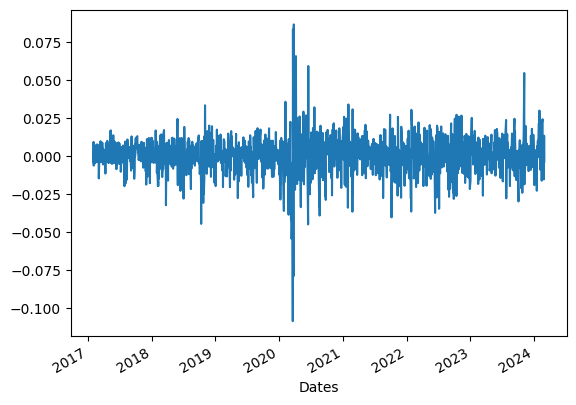

In [369]:
(check_nav1.sum(1)-check_nav2.sum(1)).pct_change().plot()

In [99]:
nav_ret=(check_nav1.sum(1)-check_nav2.sum(1)).pct_change()

In [100]:
nav_ret[nav_ret<-.2]

Series([], dtype: float64)

In [101]:
check_nav1.sum(1).loc['2023-06-25':'2023-07-03']

Dates
2023-06-26    580250588.183113
2023-06-27     580129563.46391
2023-06-28    571578649.676059
2023-06-29    564600408.299985
2023-06-30    555414345.491364
2023-07-03    566829989.976758
dtype: object

In [102]:
temp_nav=daily_quantity.loc['2023-06-30']*temp_price.loc['2023-06-30']
temp_nav[temp_nav>0].sum() - temp_nav[temp_nav<0].sum()

1110828690.982729

In [103]:
daily_quantity.loc['2023-06-25':'2023-07-03']

,A004000,A004170,A016360,A096770,A005830,A010140,A003490,A030000,A139480,A051900,...,A361610,A259960,A323410,A377300,A402340,A329180,A138040,A373220,A137310,A383220
Dates,,,,,,,,,,,,,,,,,,,,,
2023-06-26,-65.581011,-25.01233,-76.970347,-36.118579,67.020336,-992.619581,152.15919,-287.978999,-74.128749,-3.057726,...,-80.762153,-31.557928,-273.939986,-94.976069,-76.668211,-59.416745,420.878259,-6.250253,-343.974178,0.115103
2023-06-27,-65.581011,-25.01233,-76.970347,-36.118579,67.020336,-992.619581,152.15919,-287.978999,-74.128749,-3.057726,...,-80.762153,-31.557928,-273.939986,-94.976069,-76.668211,-59.416745,420.878259,-6.250253,-343.974178,0.115103
2023-06-28,-65.581011,-25.01233,-76.970347,-36.118579,67.020336,-992.619581,152.15919,-287.978999,-74.128749,-3.057726,...,-80.762153,-31.557928,-273.939986,-94.976069,-76.668211,-59.416745,420.878259,-6.250253,-343.974178,0.115103
2023-06-29,-65.581011,-25.01233,-76.970347,-36.118579,67.020336,-992.619581,152.15919,-287.978999,-74.128749,-3.057726,...,-80.762153,-31.557928,-273.939986,-94.976069,-76.668211,-59.416745,420.878259,-6.250253,-343.974178,0.115103
2023-06-30,-79.308315,-26.723633,-19.588419,-21.143866,54.998425,209.918685,-174.480795,-328.885875,-196.892617,-12.532361,...,18.816484,-38.230897,-201.788421,-31.517971,-52.225039,-42.932908,649.177985,13.10269,-569.656581,-42.392215
2023-07-03,-79.308315,-26.723633,-19.588419,-21.143866,54.998425,209.918685,-174.480795,-328.885875,-196.892617,-12.532361,...,18.816484,-38.230897,-201.788421,-31.517971,-52.225039,-42.932908,649.177985,13.10269,-569.656581,-42.392215


In [104]:
check_nav2.sum(1).loc['2023-06-25':'2023-07-03']

Dates
2023-06-26   -543893123.705055
2023-06-27   -544927911.629416
2023-06-28   -541732618.816718
2023-06-29   -535333336.702618
2023-06-30   -555414345.491365
2023-07-03   -560290531.002424
dtype: object

In [105]:
pos_w=k100_ls_w[k100_ls_w>0].sum(1)
neg_w=k100_ls_w[k100_ls_w<0].sum(1)

<Axes: xlabel='Dates'>

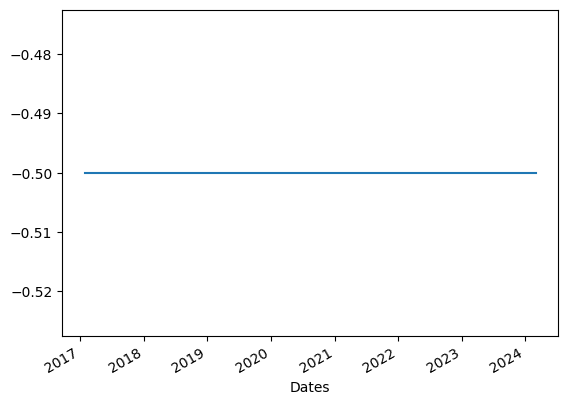

In [106]:
neg_w.plot()

In [107]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum()

624326430.475987

In [108]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()

-647563539.7614702

In [109]:
rebal_weights.iloc[0]

A004000    0.006575
A004170    0.003194
A016360   -0.003363
A096770    0.006822
A005830   -0.002095
             ...   
A329180    0.000000
A138040    0.000000
A373220    0.000000
A137310    0.000000
A383220    0.000000
Name: 2017-01-26 00:00:00, Length: 141, dtype: float64

In [110]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]>0]*temp_price.loc[date]).sum()

624326430.475987

In [111]:
(daily_quantity.loc[prev_date][daily_quantity.loc[prev_date]<0]*temp_price.loc[date]).sum()

-647563539.7614702

In [112]:
(1+ (nav1.pct_change()-nav2.pct_change())).cumprod()

Dates
2017-01-26         NaN
2017-01-31    0.983567
2017-02-01    0.988313
2017-02-02    0.998536
2017-02-03    0.994380
                ...   
2024-02-23    0.857414
2024-02-26    0.857621
2024-02-27    0.861290
2024-02-28    0.852674
2024-02-29    0.879564
Length: 1743, dtype: float64

In [113]:
nav1.pct_change()

Dates
2017-01-26         NaN
2017-01-31   -0.012371
2017-02-01    0.011594
2017-02-02   -0.001217
2017-02-03    0.000087
                ...   
2024-02-23    0.006735
2024-02-26   -0.015374
2024-02-27   -0.007614
2024-02-28    0.008211
2024-02-29    0.012190
Length: 1743, dtype: float64

<Axes: xlabel='Dates'>

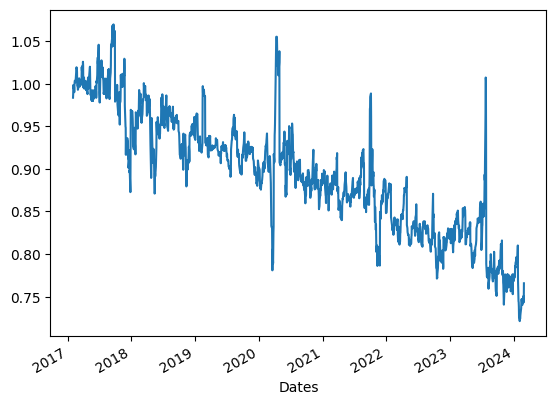

In [114]:
(1+daily_ret).cumprod().plot()

In [115]:
nav.pct_change()

NameError: name 'nav' is not defined

In [ ]:
(1+daily_ret.sum(1)).cumprod()

In [ ]:
(rebal_weights<0).sum(1)>0

In [409]:
daily_weight=pd.DataFrame(None, columns=k100_ls_w.columns, index=adjprc.loc[k100_ls_w.index[0]:k100_ls_w.index[-1]].index)

In [410]:
daily_weight.loc[k100_ls_w.index]=k100_ls_w.fillna(0)

In [411]:
daily_weight=daily_weight.ffill()

In [412]:
daily_ret_v2=(daily_weight.shift(1)*adjprc.pct_change().loc[k100_ls_w.index[0]:k100_ls_w.index[-1]]).sum(1)

/tmp/ipykernel_2982978/577972891.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_ret_v2=(daily_weight.shift(1)*adjprc.pct_change().loc[k100_ls_w.index[0]:k100_ls_w.index[-1]]).sum(1)


<Axes: xlabel='Dates'>

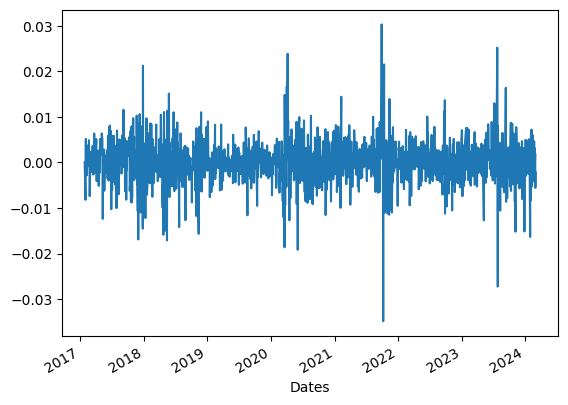

In [413]:
daily_ret_v2.plot()

<Axes: xlabel='Dates'>

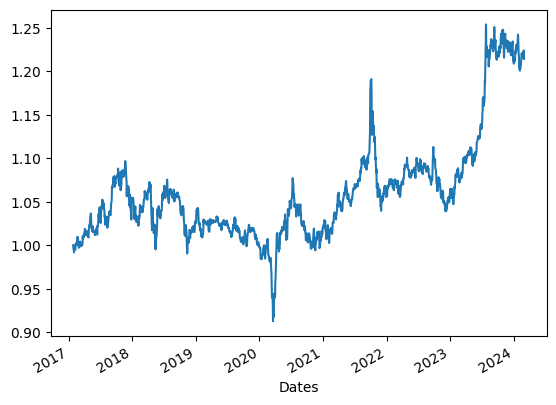

In [414]:
(1+daily_ret_v2).cumprod().plot()

<Axes: xlabel='Dates'>

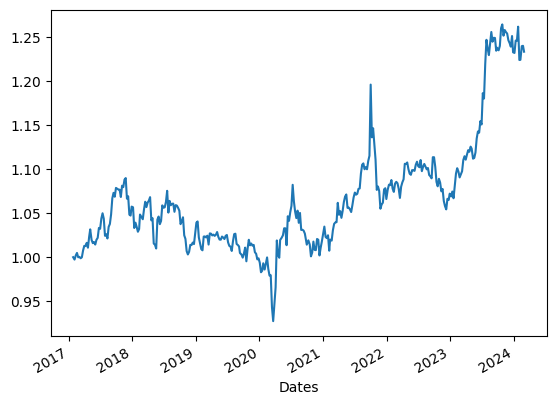

In [415]:
(1+k100_idx_ret.sum(1)).cumprod().plot()

<Axes: xlabel='Dates'>

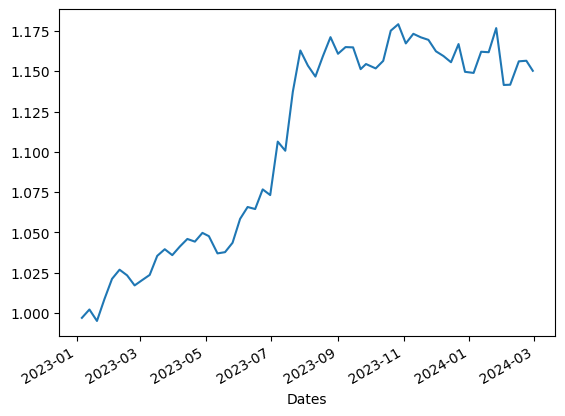

In [416]:
(1+k100_idx_ret.loc['2023-01-01':].sum(1)).cumprod().plot()

In [417]:
idx_daily_cost, idx_cum_cost=perf.apply_trading_cost(daily_ret_v2, k100_ls_w)

<Axes: xlabel='Dates'>

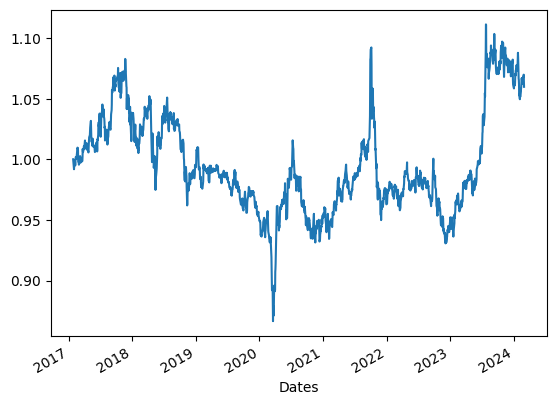

In [418]:
idx_cum_cost.plot()

In [419]:
k100ls_entire = perf.analyze_performance(daily_ret_v2,
                                     weights = daily_weight,
                                     model_name = 'k100ls')

/home/hyungshin.lee/post analysis/../py/performance.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = (1+final_return).cumprod()[-1] -1
/home/hyungshin.lee/post analysis/../py/performance.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = ((1+final_return).cumprod()[-1]**(base_date_period/(len(final_return))))-1 # geometric mean
/opt/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or

In [420]:
k100ls_entire

,cum return(%),cagr(%),vol(te),sharpe(ir),mdd(%),turnover(%),start date,end date
k100ls,21.43,2.85,0.07,0.39,-16.78,184.38,2017-01-26,2024-02-29


In [421]:
k100ls_2023 = perf.analyze_performance(daily_ret_v2.loc['2023-01-01':],
                                       weights = daily_weight,
                                       model_name = 'k100ls2023')

/home/hyungshin.lee/post analysis/../py/performance.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = (1+final_return).cumprod()[-1] -1
/home/hyungshin.lee/post analysis/../py/performance.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = ((1+final_return).cumprod()[-1]**(base_date_period/(len(final_return))))-1 # geometric mean
/opt/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or

In [422]:
k100ls_2023

,cum return(%),cagr(%),vol(te),sharpe(ir),mdd(%),turnover(%),start date,end date
k100ls2023,14.83,12.96,0.08,1.64,-4.24,184.38,2023-01-02,2024-02-29


In [423]:
k100ls_2024 = perf.analyze_performance(daily_ret_v2.loc['2024-01-01':],
                                       weights = daily_weight,
                                       model_name = 'k100ls2023')

/home/hyungshin.lee/post analysis/../py/performance.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = (1+final_return).cumprod()[-1] -1
/home/hyungshin.lee/post analysis/../py/performance.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = ((1+final_return).cumprod()[-1]**(base_date_period/(len(final_return))))-1 # geometric mean
/opt/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or

In [424]:
k100ls_2024

,cum return(%),cagr(%),vol(te),sharpe(ir),mdd(%),turnover(%),start date,end date
k100ls2023,0.17,1.03,0.07,0.15,-3.34,184.38,2024-01-02,2024-02-29


# optimize port

### how to optimize 
#### compare with market weight 
#### input: k200 weight, score, vol(return)


In [143]:
from scipy.optimize import minimize
import numpy as np

In [425]:
bmw=k200_df['idx_weight'].unstack()

In [426]:
adjprc.pct_change(60)

/tmp/ipykernel_2982978/4222830641.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  adjprc.pct_change(60)


Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A460860,A462520,A465770,A900030,A900050,A900140,A950010,A950070,A950100,A950210
Dates,,,,,,,,,,,,,,,,,,,,,
2014-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,NaN,-0.036290,0.0,1.943820,-0.038117,0.0,0.022857,-0.118790,NaN,0.184755,...,-0.130961,-0.135731,-0.359014,NaN,0.0,0.135496,0.0,NaN,0.0,-0.050214
2024-03-26,NaN,-0.042169,0.0,2.026316,-0.037373,0.0,0.052857,-0.111349,NaN,0.164425,...,-0.117827,-0.130435,-0.308511,NaN,0.0,0.202358,0.0,NaN,0.0,-0.058252
2024-03-27,NaN,-0.046371,0.0,1.927746,-0.044218,0.0,0.049419,-0.061364,NaN,0.123711,...,-0.062041,-0.132048,-0.301626,NaN,0.0,0.189824,0.0,NaN,0.0,-0.094930


In [525]:
k200_df.index.get_level_values(0).unique()[k200_df.index.get_level_values(0).unique()>'2021-12-22']

DatetimeIndex(['2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07',
               ...
               '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-04-01', '2024-04-02'],
              dtype='datetime64[ns]', name='Dates', length=559, freq=None)

In [528]:
comm_dates=ls_w.index.intersection(k200_df.index.get_level_values(0).unique())
rebal_dates = proc.find_entire_rebalancing_dates(comm_dates)

lack of the beginning part of data  2016-12-31 00:00:00 2017-01-26 00:00:00
expected date is not in inner dates 2017-01-31 00:00:00
2017-01-31 00:00:00 2017-01-26 00:00:00
expected date is not in inner dates 2017-02-28 00:00:00
2017-02-28 00:00:00 2017-02-24 00:00:00
expected date is not in inner dates 2017-04-30 00:00:00
2017-04-30 00:00:00 2017-04-28 00:00:00
expected date is not in inner dates 2017-05-31 00:00:00
2017-05-31 00:00:00 2017-05-26 00:00:00
expected date is not in inner dates 2017-07-31 00:00:00
2017-07-31 00:00:00 2017-07-28 00:00:00
expected date is not in inner dates 2017-08-31 00:00:00
2017-08-31 00:00:00 2017-08-25 00:00:00
expected date is not in inner dates 2017-09-30 00:00:00
2017-09-30 00:00:00 2017-09-29 00:00:00
expected date is not in inner dates 2017-10-31 00:00:00
2017-10-31 00:00:00 2017-10-27 00:00:00
expected date is not in inner dates 2017-11-30 00:00:00
2017-11-30 00:00:00 2017-11-24 00:00:00
expected date is not in inner dates 2017-12-31 00:00:00
2017

In [529]:
rebal_dates

DatetimeIndex(['2017-01-26', '2017-02-24', '2017-03-31', '2017-04-28',
               '2017-05-26', '2017-06-30', '2017-07-28', '2017-08-25',
               '2017-09-29', '2017-10-27', '2017-11-24', '2017-12-28',
               '2018-01-26', '2018-02-23', '2018-03-30', '2018-04-27',
               '2018-05-25', '2018-06-29', '2018-07-27', '2018-08-31',
               '2018-09-28', '2018-10-26', '2018-11-30', '2018-12-28',
               '2019-01-25', '2019-02-28', '2019-03-29', '2019-04-26',
               '2019-05-31', '2019-06-28', '2019-07-26', '2019-08-30',
               '2019-09-27', '2019-10-25', '2019-11-29', '2019-12-27',
               '2020-01-31', '2020-02-28', '2020-03-27', '2020-04-29',
               '2020-05-29', '2020-06-26', '2020-07-31', '2020-08-28',
               '2020-09-29', '2020-10-30', '2020-11-27', '2020-12-30',
               '2021-01-29', '2021-02-26', '2021-03-26', '2021-04-30',
               '2021-05-28', '2021-06-25', '2021-07-30', '2021-08-27',
      

In [533]:
bmw

Symbol,A000030,A000050,A000060,A000070,A000080,A000100,A000120,A000140,A000150,A000210,...,A352820,A361610,A373220,A375500,A377300,A381970,A383220,A383800,A402340,A450080
Dates,,,,,,,,,,,,,,,,,,,,,
2016-06-02,0.46,0.03,NaN,0.1,0.12,0.39,0.28,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-03,0.45,0.03,NaN,0.1,0.11,0.40,0.29,0.01,0.11,0.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-07,0.45,0.03,NaN,0.1,0.11,0.39,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-08,0.45,0.03,NaN,0.1,0.11,0.40,0.30,0.01,0.10,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-09,0.44,0.03,NaN,0.1,0.11,0.39,0.29,0.02,0.11,0.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,NaN,NaN,NaN,NaN,0.05,0.37,0.11,NaN,0.09,0.05,...,0.33,0.16,1.17,0.09,0.22,NaN,0.09,NaN,0.62,0.13
2024-03-28,NaN,NaN,NaN,NaN,0.05,0.38,0.11,NaN,0.09,0.05,...,0.34,0.15,1.15,0.09,0.22,NaN,0.09,NaN,0.61,0.13
2024-03-29,NaN,NaN,NaN,NaN,0.05,0.37,0.10,NaN,0.09,0.05,...,0.34,0.15,1.12,0.09,0.21,NaN,0.09,NaN,0.61,0.12


In [674]:
ls_w.iloc[-1].describe()

count    199.000000
mean      -0.001727
std        0.008387
min       -0.041879
25%       -0.004335
50%       -0.001255
75%        0.001662
max        0.041879
Name: 2024-02-29 00:00:00, dtype: float64

In [826]:
import optuna

In [942]:
bmw.iloc[-1].describe()

count    200.000000
mean       0.499650
std        2.381525
min        0.010000
25%        0.060000
50%        0.120000
75%        0.300000
max       32.370000
Name: 2024-04-02 00:00:00, dtype: float64

In [827]:


def score_objective(weight, bm_weight, score, cov):
    w_diff=weight-bm_weight
#    print(w_diff)
    port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    adj_sharpe=(w_diff*score).sum() / port_vol
    # print(adj_sharpe)
    return -adj_sharpe
    

def port_objective(trial):
    long_num=trial.suggest_int("long num", -100, -20)
    short_num=trial.suggest_int("short num", 0, 100)
    # excess_w=trial.suggest_float("excess weight", 0.02, 0.05)
    excess_w=.03
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        temp_bm_weight=bmw.loc[rebal_date].dropna()
        temp_bm_weight=temp_bm_weight.fillna(0)
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
    
        comm_col=ls_w.loc[rebal_date].dropna().index.intersection(temp_bm_weight.index)
        temp_score=ls_w.loc[rebal_date, comm_col]
    
        sort_score=temp_score.sort_values().dropna().copy()
        temp_score[:]=temp_score.mean()
        if short_num>0:
            temp_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]
    
        temp_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]
        
        # temp_score=temp_score.fillna(0).
        
        temp_cov=adjprc.loc[:rebal_date, comm_col].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
        
        if temp_bm_weight.min() <0:
            temp_score=temp_score+temp_bm_weight.min()+temp_bm_weight.std()
    
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        constraints2 = ({'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight.loc[comm_col])+excess_w})
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(comm_col)))
        
        # Initial guess (equal weights)
        initial_guess = [1 / len(comm_col) for asset in range(len(comm_col))]
        # initial_guess = temp_bm_weight
        
        # Perform the optimization
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight.loc[comm_col], temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=[constraints, constraints2])
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=comm_col, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()
    daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_opt_cumret[-1]

In [830]:
study=optuna.create_study(direction='maximize')
study.optimize(port_objective, n_trials=30)

[I 2024-04-05 17:23:38,144] A new study created in memory with name: no-name-eff55a6f-0bfe-45ad-9b2d-6ebd21522a17


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00
2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00
2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00
2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 17:36:52,569] Trial 0 finished with value: 1.430228143929085 and parameters: {'long num': -98, 'short num': 86, 'excess weight': 0.03202168550868774}. Best is trial 0 with value: 1.430228143929085.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00
2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00
2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 17:50:12,301] Trial 1 finished with value: 1.4480934867194561 and parameters: {'long num': -73, 'short num': 79, 'excess weight': 0.034390925448123034}. Best is trial 1 with value: 1.4480934867194561.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00
2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00
2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00
2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 18:03:55,836] Trial 2 finished with value: 1.30371332464152 and parameters: {'long num': -23, 'short num': 60, 'excess weight': 0.02027554469833702}. Best is trial 1 with value: 1.4480

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 18:15:50,515] Trial 3 finished with value: 1.5098197518273346 and parameters: {'long num': -98, 'short num': 74, 'excess weight': 0.046542751040658886}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00
2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 18:28:08,584] Trial 4 finished with value: 1.4259052306317919 and parameters: {'long num': -73, 'short num': 18, 'excess weight': 0.032589024245705395}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00
2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 18:40:14,996] Trial 5 finished with value: 1.4786844469421412 and parameters: {'long num': -27, 'short num': 19, 'excess weight': 0.04927462911217453}. Best is trial 3 with value: 1.50

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00
2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00
2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00
2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00
2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 18:53:38,387] Trial 6 finished with value: 1.301851871097177 and parameters: {'long num': -83, 'short num': 19, 'excess weight': 0.02880106692654305}. Best is trial 3 with value: 1.509

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00
2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00
2022-07-29 00:00:00
2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00
2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 19:07:00,974] Trial 7 finished with value: 1.3425615992869446 and parameters: {'long num': -66, 'short num': 27, 'excess weight': 0.020218868872396375}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00
2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00
2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00
2021-01-29 00:00:00
2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00
2021-07-30 00:00:00
2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 19:19:59,486] Trial 8 finished with value: 1.3287892219278759 and parameters: {'long num': -66, 'short num': 84, 'excess weight': 0.031160776992326607}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00
2017-09-29 00:00:00
2017-10-27 00:00:00
2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00
2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 19:32:38,538] Trial 9 finished with value: 1.3955362317982916 and parameters: {'long num': -74, 'short num': 94, 'excess weight': 0.029553802468400045}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00
2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00
2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00
2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 19:43:37,056] Trial 10 finished with value: 1.3524794475390272 and parameters: {'long num': -46, 'short num': 49, 'excess weight': 0.04684545343688867}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00
2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00
2022-07-29 00:00:00
2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 19:53:51,326] Trial 11 finished with value: 1.480818993235553 and parameters: {'long num': -43, 'short num': 0, 'excess weight': 0.04923754368061909}. Best is trial 3 with value: 1.5098197518273346.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00
2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00
2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 20:05:23,930] Trial 12 finished with value: 1.4119669340604482 and parameters: {'long num': -43, 'short num': 58, 'excess weight': 0.044285386577907364}. Best is trial 3 with value: 1.5098197518273346.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00
2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00
2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 20:16:40,490] Trial 13 finished with value: 1.4824819813396162 and parameters: {'long num': -50, 'short num': 5, 'excess weight': 0.04293058796410104}. Best is trial 3 with value: 1.50

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00
2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 20:28:05,693] Trial 14 finished with value: 1.4267366047002834 and parameters: {'long num': -94, 'short num': 42, 'excess weight': 0.042079089911066306}. Best is trial 3 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 20:40:41,760] Trial 15 finished with value: 1.5080339465845278 and parameters: {'long num': -53, 'short num': 70, 'excess weight': 0.040954092266070996}. Best is trial 3 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00
2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00
2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00
2021-01-29 00:00:00
2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00
2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 20:52:31,402] Trial 16 finished with value: 1.394994540717689 and parameters: {'long num': -54, 'short num': 70, 'excess weight': 0.038376158691690906}. Best is trial 3 with value: 1.5098197518273346.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00
2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00
2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00
2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 21:04:04,840] Trial 17 finished with value: 1.4174482672248854 and parameters: {'long num': -88, 'short num': 100, 'excess weight': 0.038158523424391265}. Best is trial 3 with value: 1

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 21:15:45,917] Trial 18 finished with value: 1.3492489998418793 and parameters: {'long num': -34, 'short num': 71, 'excess weight': 0.04482652644529584}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00
2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00
2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00
2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00
2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 21:27:13,375] Trial 19 finished with value: 1.4335641475801804 and parameters: {'long num': -56, 'short num': 70, 'excess weight': 0.04066603270307907}. Best is trial 3 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 21:38:42,858] Trial 20 finished with value: 1.5248450386553225 and parameters: {'long num': -82, 'short num': 40, 'excess weight': 0.04707837983511386}. Best is trial 20 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00
2021-09-24 00:00:00
2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00
2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00
2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00
2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 21:49:14,184] Trial 21 finished with value: 1.538423086941673 and parameters: {'long num': -84, 'short num': 38, 'excess weight': 0.046313649753548486}. Best is trial 21 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00
2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00
2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:00:34,366] Trial 22 finished with value: 1.430495264834385 and parameters: {'long num': -83, 'short num': 36, 'excess weight': 0.04691481591864553}. Best is trial 21 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00
2018-03-30 00:00:00
2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00
2020-12-30 00:00:00
2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00
2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:11:33,633] Trial 23 finished with value: 1.5266197946114535 and parameters: {'long num': -92, 'short num': 37, 'excess weight': 0.04973032162035104}. Best is trial 21 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00
2018-04-27 00:00:00
2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00
2020-03-27 00:00:00
2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00
2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:23:07,910] Trial 24 finished with value: 1.549192384800394 and parameters: {'long num': -85, 'short num': 33, 'excess weight': 0.04991743759521709}. Best is trial 24 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00
2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00
2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00
2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00
2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:35:01,276] Trial 25 finished with value: 1.571975113674551 and parameters: {'long num': -90, 'short num': 35, 'excess weight': 0.04968680731890403}. Best is trial 25 with value: 1.5

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00
2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00
2019-05-31 00:00:00
2019-06-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00
2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00
2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:46:04,745] Trial 26 finished with value: 1.6297159266787575 and parameters: {'long num': -78, 'short num': 29, 'excess weight': 0.04910092330175089}. Best is trial 26 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00
2018-10-26 00:00:00
2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00
2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00
2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00
2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00
2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00
2023-05-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 22:58:04,997] Trial 27 finished with value: 1.6374327079221056 and parameters: {'long num': -77, 'short num': 28, 'excess weight': 0.04983725986486014}. Best is trial 27 with value: 1.

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00
2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00
2018-05-25 00:00:00
2018-06-29 00:00:00
2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00
2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00
2020-12-30 00:00:00
2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00
2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00
2023-04-28 00:00:00
2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 23:10:46,884] Trial 28 finished with value: 1.5319246952020336 and parameters: {'long num': -77, 'short num': 26, 'excess weight': 0.04449594176205387}. Best is trial 27 with value: 1.6374327079221056.


2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00
2017-07-28 00:00:00
2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00
2018-11-30 00:00:00
2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00
2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-05-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-06-26 00:00:00
2020-07-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-08-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-09-29 00:00:00
2020-10-30 00:00:00
2020-11-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00
2021-03-26 00:00:00
2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-09-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-11-25 00:00:00
2022-12-29 00:00:00
2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
/tmp/ipykernel_2982978/2823616981.py:67: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
/tmp/ipykernel_2982978/2823616981.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_opt_cumret[-1]
[I 2024-04-05 23:23:25,594] Trial 29 finished with value: 1.4456488241553573 and parameters: {'long num': -64, 'short num': 11, 'excess weight': 0.0479871871337234}. Best is trial 27 with value: 1.6

In [831]:
study.best_trials

[FrozenTrial(number=27, state=1, values=[1.6374327079221056], datetime_start=datetime.datetime(2024, 4, 5, 22, 46, 4, 746638), datetime_complete=datetime.datetime(2024, 4, 5, 22, 58, 4, 996728), params={'long num': -77, 'short num': 28, 'excess weight': 0.04983725986486014}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'long num': IntDistribution(high=-20, log=False, low=-100, step=1), 'short num': IntDistribution(high=100, log=False, low=0, step=1), 'excess weight': FloatDistribution(high=0.05, log=False, low=0.02, step=None)}, trial_id=27, value=None)]

In [866]:
def optimize_portfolio(raw_weight, bm_weight, rebal_dates, long_num, short_num, excess_w):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
        temp_bm_weight=temp_bm_weight.fillna(0)
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()
    
        comm_col=raw_weight.loc[rebal_date].dropna().index.intersection(temp_bm_weight.index)
        temp_score=raw_weight.loc[rebal_date, comm_col]
    
        sort_score=temp_score.sort_values().dropna().copy()
        temp_score[:]=temp_score.mean()
        if short_num>0:
            temp_score[sort_score.iloc[:short_num].index]=sort_score.iloc[:short_num]
    
        temp_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]
        
        # temp_score=temp_score.fillna(0).        
        temp_cov=adjprc.loc[:rebal_date, comm_col].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
        
        if temp_bm_weight.min() <0:
            temp_score=temp_score+temp_bm_weight.min()+temp_bm_weight.std()
    
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        constraints2 = ({'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight.loc[comm_col])+excess_w})
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(comm_col)))
        
        # Initial guess (equal weights)
        initial_guess = [1 / len(comm_col) for asset in range(len(comm_col))]
        # initial_guess = temp_bm_weight
        
        # Perform the optimization
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight.loc[comm_col], temp_score, temp_cov),
                          method='SLSQP', bounds=bounds, constraints=[constraints, constraints2])
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=comm_col, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()
    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw


In [909]:
daily_optw=optimize_portfolio(ls_w, bmw, rebal_dates, -75, 30, .03)

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-08-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-09-29 00:00:00
2017-10-27 00:00:00
2017-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-02-23 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-03-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-04-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00
2018-06-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-01-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00
2019-03-29 00:00:00
2019-04-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00
2019-06-28 00:00:00
2019-07-26 00:00:00
2019-08-30 00:00:00
2019-09-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-10-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-11-29 00:00:00
2019-12-27 00:00:00
2020-01-31 00:00:00
2020-02-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-03-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00
2020-10-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00
2020-12-30 00:00:00
2021-01-29 00:00:00
2021-02-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00
2021-06-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-08-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00
2022-01-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-02-25 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00
2022-04-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-05-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00
2022-10-28 00:00:00
2022-11-25 00:00:00
2022-12-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00
2023-02-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-03-31 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-04-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-05-26 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-07-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-11-24 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-12-28 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-02-29 00:00:00


/tmp/ipykernel_2982978/2823616981.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


In [959]:
def score_objective(weight, bm_weight, score, cov):
    w_diff=weight-bm_weight
    # print(w_diff)
    port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))
    adj_sharpe=(w_diff*score).sum() / port_vol
    # print(adj_sharpe)
    return -adj_sharpe
    
def optimize_portfolio(raw_weight, bm_weight, rebal_dates, excess_w):
    
    optw_ls=[]
    for rebal_date in rebal_dates:
        print(rebal_date)
        temp_bm_weight=bm_weight.loc[rebal_date].dropna()
        temp_bm_weight=temp_bm_weight.fillna(0)
        temp_bm_weight=temp_bm_weight/temp_bm_weight.sum()

        temp_raw_weight=raw_weight.loc[rebal_date]
        comm_col=temp_raw_weight.dropna().index.intersection(temp_bm_weight.index)
        temp_score=pd.DataFrame(temp_raw_weight.loc[comm_col].mean(), 
                                index= temp_bm_weight.index, 
                                columns=[rebal_date])
        temp_score.loc[comm_col, rebal_date]=temp_raw_weight.loc[comm_col]
    
        # sort_score=temp_score.sort_values().dropna().copy()
        # fill with mean score 
        # temp_score[:]=temp_score.mean()
        # temp_score[sort_score.iloc[-long_num:].index]=sort_score.iloc[-long_num:]
        
        # temp_score=temp_score.fillna(0).        
        temp_cov=adjprc.loc[:rebal_date, comm_col].pct_change(20).dropna(how='all', axis=0).cov()
        temp_cov=temp_cov.fillna(0)
        
        if temp_bm_weight.min() <0:
            temp_score=temp_score+temp_bm_weight.min()+temp_bm_weight.std()
    
        # if temp_cov.shape[0] == temp_bm_weight.shape[0] == temp_score.shape[0]:
        #     raise ValueError(rebal_date, 'data are not aligned', temp_cov.shape[0], temp_bm_weight.shape[0], temp_score.shape[0])
        
        # Define the constraints (weights sum to 1)
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        constraints2 = ({'type': 'ineq', 'fun': lambda x: -np.abs(x - temp_bm_weight.loc[comm_col])+excess_w})
        
        # Define the bounds (each weight is between 0 and 1)
        bounds = tuple((0, 1) for asset in range(len(comm_col)))
        
        # Initial guess (equal weights)
        initial_guess = [1 / len(comm_col) for asset in range(len(comm_col))]
        # initial_guess = temp_bm_weight
        
        # Perform the optimization
        result = minimize(score_objective, initial_guess, args=(temp_bm_weight.loc[comm_col], temp_score[rebal_date], temp_cov),
                          method='SLSQP', bounds=bounds, constraints=[constraints, constraints2])
        
        # Extract the optimized weights
        optimal_weights = result.x
        optw_df=pd.DataFrame(optimal_weights, index=comm_col, columns=[rebal_date])
        optw_ls.append(optw_df)
        # print("Optimal Weights:", optimal_weights)
    
    optw_port=pd.concat(optw_ls, axis=1).T
    daily_optw=pd.DataFrame(None, index=adjprc.loc[optw_port.index[0]:optw_port.index[-1]].index, columns=optw_port.columns)
    daily_optw.loc[optw_port.index]=optw_port.fillna(0)
    daily_optw=daily_optw.ffill()
    # daily_opt_port_ret=daily_optw*adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]
    # daily_opt_cumret=(1+daily_opt_port_ret.sum(1)).cumprod()

    return daily_optw


In [960]:
daily_optw=optimize_portfolio(ls_w, bmw, rebal_dates, .03)

2017-01-26 00:00:00
2017-02-24 00:00:00
2017-03-31 00:00:00
2017-04-28 00:00:00
2017-05-26 00:00:00
2017-06-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-07-28 00:00:00
2017-08-25 00:00:00
2017-09-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-10-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2017-11-24 00:00:00
2017-12-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-01-26 00:00:00
2018-02-23 00:00:00
2018-03-30 00:00:00
2018-04-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-05-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-06-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-07-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-08-31 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-09-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-10-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-11-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2018-12-28 00:00:00
2019-01-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-02-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-03-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-04-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-05-31 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-06-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-07-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-08-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-09-27 00:00:00
2019-10-25 00:00:00
2019-11-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2019-12-27 00:00:00
2020-01-31 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-02-28 00:00:00
2020-03-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-04-29 00:00:00
2020-05-29 00:00:00
2020-06-26 00:00:00
2020-07-31 00:00:00
2020-08-28 00:00:00
2020-09-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-10-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-11-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2020-12-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-01-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-02-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-03-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-04-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-05-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-06-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-07-30 00:00:00
2021-08-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-09-24 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-10-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-11-26 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2021-12-24 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-01-28 00:00:00
2022-02-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-03-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-04-29 00:00:00
2022-05-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-06-24 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-07-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-08-26 00:00:00
2022-09-30 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-10-28 00:00:00
2022-11-25 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2022-12-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-01-27 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-02-24 00:00:00
2023-03-31 00:00:00
2023-04-28 00:00:00
2023-05-26 00:00:00
2023-06-30 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2023-08-25 00:00:00
2023-09-27 00:00:00
2023-10-27 00:00:00
2023-11-24 00:00:00
2023-12-28 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


2024-01-26 00:00:00
2024-02-29 00:00:00


/tmp/ipykernel_2982978/2135996016.py:4: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(w_diff.T, np.dot(cov, w_diff)))


<Axes: xlabel='Dates'>

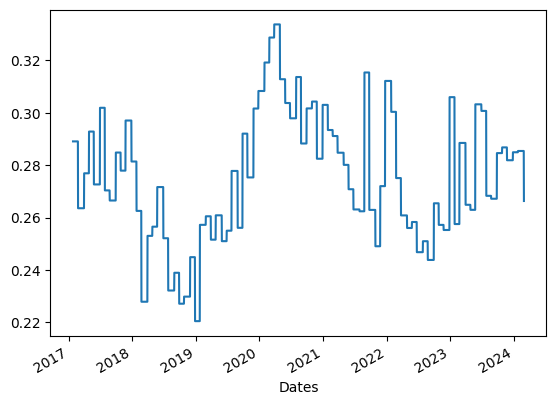

In [961]:
daily_optw['A005930'].plot()

<Axes: xlabel='Dates'>

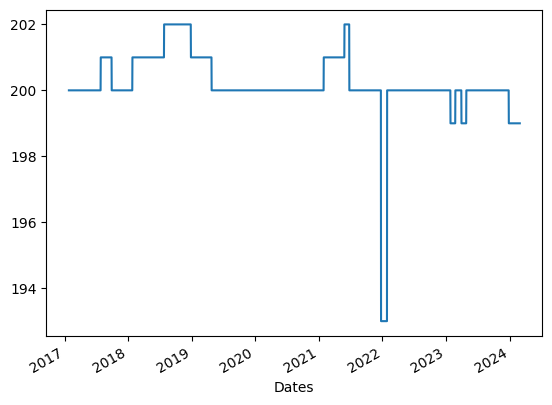

In [962]:
daily_optw[daily_optw>0].count(1).plot()

In [963]:
daily_optw=daily_optw.div(daily_optw.sum(1), axis=0)

In [964]:
daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw

/tmp/ipykernel_2982978/3117912796.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  daily_optret=adjprc.pct_change().loc[daily_optw.index, daily_optw.columns]*daily_optw


In [965]:
daily_optret.sum(1)

Dates
2017-01-26    0.009062
2017-01-31   -0.008835
2017-02-01    0.005602
2017-02-02   -0.004063
2017-02-03    0.000833
                ...   
2024-02-23    0.001896
2024-02-26   -0.008709
2024-02-27   -0.007518
2024-02-28    0.010147
2024-02-29   -0.002307
Length: 1743, dtype: float64

In [966]:
daily_opt_cumret=(1+daily_optret.sum(1)).cumprod()

In [967]:
daily_opt_cumret

Dates
2017-01-26    1.009062
2017-01-31    1.000146
2017-02-01    1.005749
2017-02-02    1.001663
2017-02-03    1.002497
                ...   
2024-02-23    1.377395
2024-02-26    1.365400
2024-02-27    1.355135
2024-02-28    1.368885
2024-02-29    1.365728
Length: 1743, dtype: float64

In [968]:
excess_ret=(daily_optret.sum(1)-krx_idx['코스피 200'].pct_change().loc[daily_optw.index])

<Axes: xlabel='Dates'>

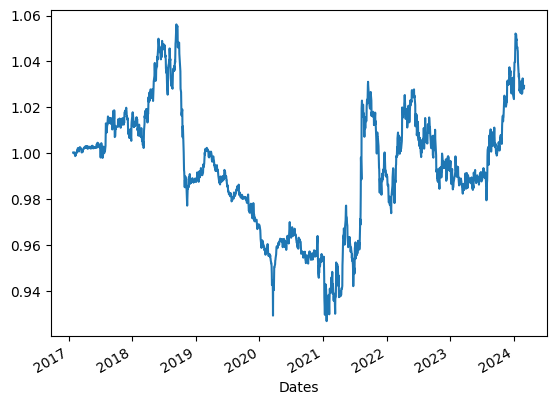

In [969]:
(1+excess_ret).cumprod().plot()

In [970]:
bm_cumret=(1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

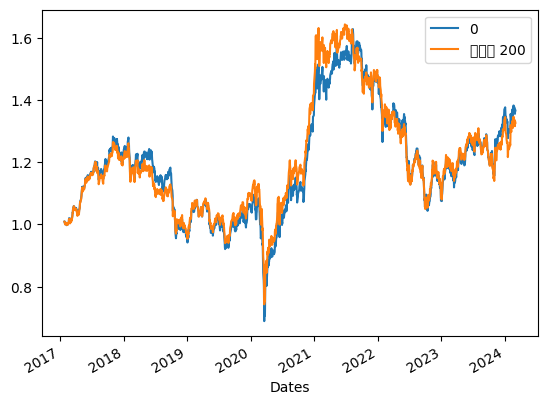

In [971]:
pd.concat([daily_opt_cumret, bm_cumret], axis=1).plot()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

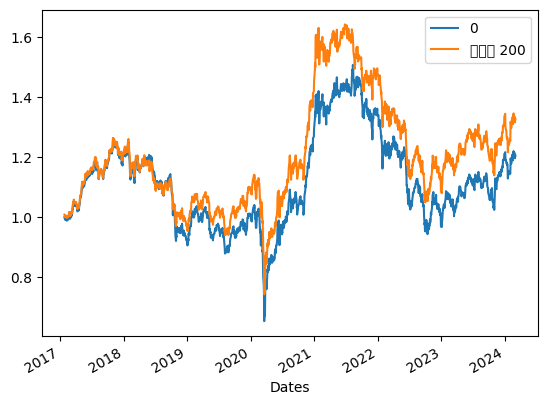

In [972]:
# 70
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[daily_optw.index, 
                                                                        daily_optw.columns], 
                                                                        daily_optw,
                                                                        cost=0.002)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_optw.index]).cumprod()], axis=1).plot()

In [ ]:
a

In [922]:
daily_optw.iloc[-1].sort_values(ascending=False).loc[['A005930', 'A000660']]

A005930    0.266155
A000660    0.078133
Name: 2024-02-29 00:00:00, dtype: float64

In [933]:
adjprc.loc['2023-12-25':'2024-01-02'].index

DatetimeIndex(['2023-12-26', '2023-12-27', '2023-12-28', '2024-01-02'], dtype='datetime64[ns]', name='Dates', freq=None)

In [934]:
recent_date='2023-12-28'
recentw=pd.DataFrame(None, index=adjprc.loc[recent_date:].index, columns=daily_optw.columns)

In [935]:
recentw.loc[recent_date]=daily_optw.iloc[-1]

In [936]:
recentw=recentw.ffill()

In [937]:
recent_ret=recentw*adjprc.pct_change().loc[recentw.index, recentw.columns]

/tmp/ipykernel_2982978/4140963655.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  recent_ret=recentw*adjprc.pct_change().loc[recentw.index, recentw.columns]


<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

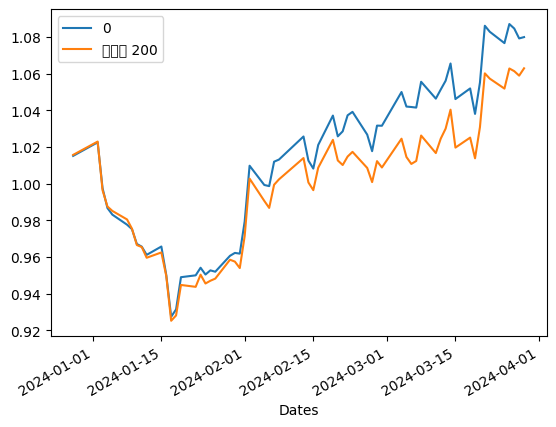

In [938]:
(1+pd.concat([recent_ret.sum(1), krx_idx['코스피 200'].pct_change().loc[recent_date:]], axis=1)).cumprod().plot()

In [485]:
optw_df.sort_values('opt_w')

,opt_w
A300720,1.215774e-10
A069260,1.870325e-10
A006280,2.415086e-10
A000670,2.431012e-10
A006260,2.957588e-10
...,...
A005490,2.484448e-02
A068270,2.620941e-02
A005380,2.638476e-02
A000660,7.829448e-02


In [486]:
(optw_df['opt_w']-temp_bm_weight).sort_values()

A005930   -0.030134
A015760   -0.005232
A000270   -0.004804
A373220   -0.004307
A034730   -0.004039
             ...   
A006800    0.006088
A009150    0.006133
A003410    0.006190
A003620    0.009309
A029780    0.011127
Length: 199, dtype: float64

In [461]:
temp_bm_weight.sort_values()

A000670    0.000200
A271940    0.000200
A105630    0.000200
A300720    0.000200
A280360    0.000200
             ...   
A068270    0.025841
A000270    0.026643
A005380    0.029948
A000660    0.075120
A005930    0.296875
Name: 2024-02-29 00:00:00, Length: 199, dtype: float64

# sector neutral


### 1. (use selection only) use top score stocks only then allocate weight proportion to the actual market cap
####  if no stock is selected in a sector then follow BM 

### 2. (use selection and score) set boundary of tilt amount and do optimization using score

### 3. (use BM and score) use entire index and tilting using optimization

In [569]:
data_SSC_nodup.columns

Index(['Name', 'MNGT', 'ClosePrc', 'OpenPrc', 'HighPrc', 'LowPrc', 'AdjPrc',
       'AdjPrc2', 'AdjPrc_High_20D', 'AdjPrc_Low_20D', 'AdjPrc_High_60D',
       'AdjPrc_Low_60D', 'AdjPrc_High_120D', 'AdjPrc_Low_120D',
       'AdjPrc_High_52W', 'AdjPrc_Low_52W', 'ListedShares', 'ForeignStake',
       'TradeStop', 'MktCap_Comm_Pref', 'MktCapCom', 'MktCap', 'Volume',
       'Volume_Avg_20D', 'Volume_Avg_60D', 'Volume_Avg_120D', 'Volume_Avg_52W',
       'Amt_Avg_20D', 'Amt_Avg_60D', 'Amt_Avg_120D', 'Amt_Avg_52W', 'Vol_20D',
       'Vol_120D'],
      dtype='object')

In [570]:
data_COM_nodup.columns

Index(['Name', 'KC_Industry', 'FG_IndustryGroup27', 'FG_Sector_Idx',
       'FG_IndustryGroup_Idx', 'FG_Industry_Idx', 'AuditOpinion', 'Caution',
       'KSECapSize', 'KLCAIndustry', 'Market', 'KOSPI200YN', 'FiscalMonth',
       'KOSPI100YN'],
      dtype='object')

In [571]:
temp_com=data_COM_nodup[['KSECapSize', 'FG_Sector_Idx', 'KOSPI200YN']].copy()

In [572]:
temp_ssc=data_SSC_nodup[['MktCap']].copy()

In [573]:
bm_mktcap=pd.concat([temp_com, temp_ssc], axis=1)

In [574]:
bm_mktcap

KSECapSize FG_Sector_Idx KOSPI200YN     MktCap
Dates      Symbol                                                
2014-09-01 A005930    코스피 대형주            IT          Y  180588987
           A373220       None          None          N       None
           A000660    코스피 대형주            IT          Y   32157434
           A207940       None          None          N       None
           A051910    코스피 대형주            소재          Y   17893197
...                       ...           ...        ...        ...
2023-12-26 A109070        NaN           NaN        NaN     150922
2023-12-27 A109070        NaN           NaN        NaN     150922
2023-12-28 A109070        NaN           NaN        NaN     150922
2023-06-15 A229640        NaN           NaN        NaN     213762
           A109070        NaN           NaN        NaN     150922

[2824828 rows x 4 columns]

In [575]:
bm_mktcap=bm_mktcap[bm_mktcap['KOSPI200YN']=='Y']

In [576]:
bm_mktcap['MktCap']=bm_mktcap['MktCap'].astype(float)

/tmp/ipykernel_2982978/2714864707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_mktcap['MktCap']=bm_mktcap['MktCap'].astype(float)


In [577]:
bm_mktcap

KSECapSize FG_Sector_Idx KOSPI200YN       MktCap
Dates      Symbol                                                  
2014-09-01 A005930    코스피 대형주            IT          Y  180588987.0
           A000660    코스피 대형주            IT          Y   32157434.0
           A051910    코스피 대형주            소재          Y   17893197.0
           A006400    코스피 대형주            IT          Y   10589738.0
           A005380    코스피 대형주         경기소비재          Y   51104143.0
...                       ...           ...        ...          ...
2024-03-29 A004490    코스피 중형주         경기소비재          Y    1100400.0
           A001680    코스피 중형주         필수소비재          Y     672172.0
           A105630    코스피 중형주         경기소비재          Y     799600.0
           A022100    코스피 대형주            IT          Y    7434498.0
           A450080    코스피 대형주            IT          Y    9023267.0

[471375 rows x 4 columns]

In [578]:
bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum('MktCap')

In [579]:
# bm_sector_cap=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()

In [580]:

bm_sector_weight=bm_sector_cap /bm_mktcap.groupby(['Dates']).sum('MKtCap')

In [581]:
# temp_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')/daily_sector_weight.groupby(['Dates']).sum()

In [582]:
bm_sector=bm_mktcap['FG_Sector_Idx'].copy()
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'FG_Sector_Idx'], inplace=True)
bm_sector=pd.concat([bm_sector, bm_sector_weight], axis=1)
bm_sector=bm_sector.reset_index()
bm_sector.set_index(['Dates', 'Symbol'], inplace=True)

In [583]:
# daily_sector_weight=temp_mktcap.groupby(['Dates', 'FG_Sector_Idx']).sum()/temp_mktcap.groupby(['Dates']).sum()

In [584]:
# daily_sector_weight=bm_mktcap.groupby(['Dates', 'FG_Sector_Idx'])['MktCap'].transform('sum')
# daily_sector_weight=daily_sector_weight/daily_sector_weight.groupby(['Dates']).sum()

## stock selection from k200

In [585]:
num_selection=75
top_prob_ls = []

for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob=raw_prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection]
    tempw = scaler.fit_transform(top_prob.values.reshape(-1, 1))
    temp_w = pd.DataFrame(tempw, index = top_prob.index)
    top_prob_ls.append(temp_w)
    
top_prob_df=pd.concat(top_prob_ls, axis=1)
top_prob_df=top_prob_df.T
top_prob_df.index=raw_prob.index

top_prob_df=top_prob_df.stack().to_frame()
top_prob_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

In [586]:
cap_prob_df.dropna()

KSECapSize FG_Sector_Idx KOSPI200YN       MktCap  \
Dates      Symbol                                                     
2017-01-26 A005930    코스피 대형주            IT          Y  280655277.0   
           A051910    코스피 대형주            소재          Y   19059933.0   
           A006400    코스피 대형주            IT          Y    7976685.0   
           A005490    코스피 대형주            소재          Y   24063566.0   
           A012330    코스피 대형주         경기소비재          Y   25893468.0   
...                       ...           ...        ...          ...   
2024-02-29 A008730    코스피 중형주            소재          Y    1027960.0   
           A161890    코스피 중형주         필수소비재          Y    1085712.0   
           A003090    코스피 중형주            의료          Y    1279124.0   
           A192080    코스피 중형주            IT          Y     996335.0   
           A004490    코스피 중형주         경기소비재          Y    1114400.0   

                    MktCap_ratio  idx_weight         0  
Dates      Symbol                                       
2017-01-26 A005930      0.339837       27.91  1.000000  
           A051910      0.087542        1.77  0.343246  
           A006400      0.339837        0.79  0.019173  
           A005490      0.087542        2.71  0.089974  
           A012330      0.144470        2.40  0.553281  
...                          ...         ...       ...  
2024-02-29 A008730      0.081232        0.04  0.032043  
           A161890      0.026287        0.07  0.005817  
           A003090      0.069900        0.04  0.003875  
           A192080      0.430494        0.04  0.038578  
           A004490      0.112512        0.05  0.022895  

[27614 rows x 7 columns]

## stock selection from k100

In [587]:
top_prob_k100_ls = []

k100prob=raw_prob * k100comp.loc[raw_prob.index]

num_selection_k100=50
for i in range(len(raw_prob.index)):
    scaler = MinMaxScaler()
    top_prob_k100=k100prob.iloc[i].dropna().sort_values(ascending=False)[:num_selection_k100]
    tempw_k100 = scaler.fit_transform(top_prob_k100.values.reshape(-1, 1))
    tempw_k100 = pd.DataFrame(tempw_k100, index = top_prob_k100.index)
    top_prob_k100_ls.append(tempw_k100)
    
top_prob_k100_df=pd.concat(top_prob_k100_ls, axis=1)
top_prob_k100_df=top_prob_k100_df.T
top_prob_k100_df.index=raw_prob.index

top_prob_k100_df=top_prob_k100_df.stack().to_frame()
top_prob_k100_df.index.set_names(['Dates', 'Symbol'], inplace=True)

bm_sector.columns=[bm_sector.columns[0], 'MktCap_ratio']

cap_prob_k100_df=pd.concat([bm_mktcap, bm_sector[bm_sector.columns.difference(bm_mktcap.columns)]], axis=1)
cap_prob_k100_df=pd.concat([cap_prob_df, k200_df['idx_weight'], top_prob_k100_df], axis=1)
# cap_prob_df=pd.concat([cap_prob_df, top_prob_df], axis=1)

## rebal dates

In [ ]:
sector_dates=cap_prob_df.dropna().index.get_level_values(0).unique()
sector_dates=pd.to_datetime(sector_dates)
sector_dates=sector_dates.sort_values()

rebal_dates = proc.find_entire_rebalancing_dates(sector_dates)
rebal_dates

In [588]:
sector_ls=list(bm_sector['FG_Sector_Idx'].unique())
sector='IT'
given_samsung_weight=.3
sam_w=k200_df[k200_df.index.get_level_values(1)=='A005930']

## sector neutral port with samsung neutral

In [589]:
weight_ls=[]
for date in rebal_dates:
    print(date)
    temp_sector_cap_prob=cap_prob_df[cap_prob_df.index.get_level_values(0)==date]
    
    sector_weight_ls=[]
    for sector in sector_ls:
        
        # when there is no stock in certain sector then keep all stocks in that missing sector
        if sector not in temp_sector_cap_prob.dropna()['FG_Sector_Idx'].unique():
            print(sector)
            temp_sector_neutral=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]['idx_weight']/100
            sector_weight_ls.append(temp_sector_neutral)
            
        else:
            temp_sector_tilt=temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector].dropna()
            # temp_sector_neutral['sector_ew']=1/len(temp_sector_neutral)

            if sector=='IT':
                it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
                it_mktcap=temp_sector_tilt['MktCap'].drop(index='A005930', level='Symbol')
                it_mktcap_ratio=it_mktcap/it_mktcap.sum()*it_leftover
                it_mktcap_ratio.loc[(date, 'A005930')]=given_samsung_weight
                sector_weight_ls.append(it_mktcap_ratio)
            else:
                temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
                sector_weight_ls.append(temp_mktcap_ratio)

    weight_df=pd.concat(sector_weight_ls, axis=0)
    weight_ls.append(weight_df)

2017-01-26 00:00:00
통신서비스
nan
2017-02-24 00:00:00
통신서비스
nan
2017-03-31 00:00:00
통신서비스
nan
2017-04-28 00:00:00
통신서비스
nan
2017-05-26 00:00:00
유틸리티
통신서비스
nan
2017-06-30 00:00:00
통신서비스
nan
2017-07-28 00:00:00
유틸리티
통신서비스
nan
2017-08-25 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

유틸리티
통신서비스
nan
2017-09-29 00:00:00
통신서비스
nan
2017-10-27 00:00:00
유틸리티
통신서비스
nan
2017-11-24 00:00:00
금융
통신서비스
nan
2017-12-28 00:00:00
nan
2018-01-26 00:00:00
nan
2018-02-23 00:00:00
nan
2018-03-30 00:00:00
유틸리티
통신서비스
nan
2018-04-27 00:00:00
유틸리티
nan
2018-05-25 00:00:00
유틸리티
nan


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

2018-06-29 00:00:00
nan
2018-07-27 00:00:00
nan
2018-08-31 00:00:00
nan
2018-09-28 00:00:00
통신서비스
nan
2018-10-26 00:00:00
통신서비스
nan
2018-11-30 00:00:00
유틸리티
통신서비스
nan
2018-12-28 00:00:00
금융
유틸리티
통신서비스
nan
2019-01-25 00:00:00
nan
2019-02-28 00:00:00
nan
2019-03-29 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

통신서비스
nan
2019-04-26 00:00:00
유틸리티
통신서비스
nan
2019-05-31 00:00:00
유틸리티
nan
2019-06-28 00:00:00
유틸리티
nan
2019-07-26 00:00:00
유틸리티
nan
2019-08-30 00:00:00
유틸리티
nan
2019-09-27 00:00:00
nan
2019-10-25 00:00:00
유틸리티
통신서비스
nan
2019-11-29 00:00:00
통신서비스
nan
2019-12-27 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

nan
2020-01-31 00:00:00
통신서비스
nan
2020-02-28 00:00:00
통신서비스
nan
2020-03-27 00:00:00
nan
2020-04-29 00:00:00
통신서비스
nan
2020-05-29 00:00:00
통신서비스
nan
2020-06-26 00:00:00
유틸리티
통신서비스
nan
2020-07-31 00:00:00
유틸리티
통신서비스
nan
2020-08-28 00:00:00
유틸리티
통신서비스
nan
2020-09-29 00:00:00
유틸리티
nan
2020-10-30 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

유틸리티
통신서비스
nan
2020-11-27 00:00:00
유틸리티
nan
2020-12-30 00:00:00
유틸리티
nan
2021-01-29 00:00:00
유틸리티
통신서비스
nan
2021-02-26 00:00:00
nan
2021-03-26 00:00:00
nan
2021-04-30 00:00:00
유틸리티
nan
2021-05-28 00:00:00
유틸리티
nan
2021-06-25 00:00:00
유틸리티
통신서비스
nan
2021-07-30 00:00:00


/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

유틸리티
통신서비스
nan
2021-08-27 00:00:00
통신서비스
nan
2021-09-24 00:00:00
nan
2021-10-29 00:00:00
통신서비스
nan
2021-11-26 00:00:00
유틸리티
nan
2021-12-24 00:00:00
유틸리티
nan
2022-01-28 00:00:00
nan
2022-02-25 00:00:00
통신서비스
nan
2022-03-25 00:00:00
통신서비스
nan
2022-04-29 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

유틸리티
통신서비스
nan
2022-05-27 00:00:00
통신서비스
nan
2022-06-24 00:00:00
nan
2022-07-29 00:00:00
nan
2022-08-26 00:00:00
통신서비스
nan
2022-09-30 00:00:00
통신서비스
nan
2022-10-28 00:00:00
통신서비스
nan
2022-11-25 00:00:00
nan
2022-12-29 00:00:00
통신서비스
nan
2023-01-27 00:00:00
통신서비스
nan
2023-02-24 00:00:00


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

통신서비스
nan
2023-03-31 00:00:00
통신서비스
nan
2023-04-28 00:00:00
통신서비스
nan
2023-05-26 00:00:00
유틸리티
nan
2023-06-30 00:00:00
유틸리티
nan
2023-07-28 00:00:00
nan
2023-08-25 00:00:00
유틸리티
통신서비스
nan
2023-09-27 00:00:00
nan
2023-10-27 00:00:00
nan
2023-11-24 00:00:00
nan
2023-12-28 00:00:00
nan
2024-01-26 00:00:00
통신서비스
nan
2024-02-29 00:00:00
통신서비스
nan


/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  it_leftover=temp_sector_tilt['MktCap_ratio'][0]-sam_w.loc[date, 'idx_weight'].values/100
/tmp/ipykernel_2982978/4065449552.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_mktcap_ratio=temp_sector_tilt['MktCap']/temp_sector_tilt['MktCap'].sum()*temp_sector_tilt['MktCap_ratio'][0]
/tmp/ipykernel_2982978/4065449552.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

In [ ]:
temp_sector_cap_prob[temp_sector_cap_prob['FG_Sector_Idx']==sector]

## smoothing weights

In [ ]:
sector_neutral_weight=pd.concat(weight_ls).unstack().dropna(how='all', axis=0)
sector_neutral_weight=sector_neutral_weight.div(sector_neutral_weight.sum(1), axis=0)

temp_adj=adjprc.loc[sector_neutral_weight.index[0]:sector_neutral_weight.index[-1], sector_neutral_weight.columns].copy()
daily_w=temp_adj.copy()
daily_w.loc[sector_neutral_weight.index]=0
daily_w[daily_w!=0]=None
daily_w.loc[sector_neutral_weight.index]=sector_neutral_weight.fillna(0)
daily_w=daily_w.fillna(method='ffill')

In [ ]:
daily_w.sum(1).plot()

In [ ]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(temp_adj, 
                                                                        daily_w.shift(1),
                                                                        cost=0.003)

In [ ]:
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[daily_w.index]).cumprod()], axis=1).plot()

## k200 ew port with samsung neutral

In [590]:
top_prob_unstack=top_prob_df.unstack().copy()
top_prob_unstack.columns=top_prob_unstack.columns.get_level_values(1)

k200_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/75
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/76
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k200_weight_ls.append(temp_top_prob)

# k200 market weight

In [595]:
temp_top_prob_df=top_prob_df[top_prob_df.index.get_level_values(0).isin(rebal_dates)]

In [596]:
k200_df.index.get_level_values(0).unique(), top_prob_df.index.get_level_values(0).unique()

(DatetimeIndex(['2016-06-02', '2016-06-03', '2016-06-07', '2016-06-08',
                '2016-06-09', '2016-06-10', '2016-06-13', '2016-06-14',
                '2016-06-15', '2016-06-16',
                ...
                '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-25',
                '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
                '2024-04-01', '2024-04-02'],
               dtype='datetime64[ns]', name='Dates', length=1925, freq=None),
 DatetimeIndex(['2017-01-26', '2017-02-03', '2017-02-10', '2017-02-17',
                '2017-02-24', '2017-03-03', '2017-03-10', '2017-03-17',
                '2017-03-24', '2017-03-31',
                ...
                '2023-12-28', '2024-01-05', '2024-01-12', '2024-01-19',
                '2024-01-26', '2024-02-02', '2024-02-08', '2024-02-16',
                '2024-02-23', '2024-02-29'],
               dtype='datetime64[ns]', name='Dates', length=370, freq=None))

In [597]:
temp_k200_df=k200_df[k200_df.index.isin(temp_top_prob_df.index)]

In [598]:
temp_k200_df=temp_k200_df['idx_weight'].unstack()

In [599]:
k200_df_mask=temp_k200_df.copy()
k200_df_mask[k200_df_mask>0]=1

In [600]:
k200_df_mask

Symbol,A000080,A000810,A000990,A001060,A001120,A001680,A001740,A001780,A002270,A002960,...,A280360,A003230,A139130,A175330,A001570,A005420,A008730,A009970,A145720,A006110
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-31,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-28,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-26,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2023-11-24,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN


In [601]:
temp_samw=sam_w[sam_w.index.get_level_values(0).isin(temp_k200_df.index.get_level_values(0))]['idx_weight']
temp_samw.index=temp_samw.index.get_level_values(0)

In [602]:
temp_k200_df['A005930']=temp_samw

In [603]:
k200_df_mask.sum(1)

Dates
2017-01-26    75.0
2017-02-24    75.0
2017-03-31    75.0
2017-04-28    75.0
2017-05-26    75.0
              ... 
2023-10-27    75.0
2023-11-24    75.0
2023-12-28    75.0
2024-01-26    75.0
2024-02-29    75.0
Length: 86, dtype: float64

In [604]:
extra_weight=(100-temp_k200_df.sum(1))/k200_df_mask.sum(1)

In [605]:
temp_k200_df

Symbol,A000080,A000810,A000990,A001060,A001120,A001680,A001740,A001780,A002270,A002960,...,A280360,A003230,A139130,A175330,A001570,A005420,A008730,A009970,A145720,A006110
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.09,1.26,0.08,0.07,0.11,0.07,0.13,0.03,0.06,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-24,0.09,NaN,0.09,0.07,0.12,NaN,0.15,0.03,0.06,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-31,NaN,1.22,0.09,0.07,0.11,NaN,NaN,0.02,NaN,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-28,NaN,1.19,NaN,0.06,NaN,NaN,0.15,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-26,NaN,1.23,NaN,0.07,NaN,NaN,0.13,0.02,0.06,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,0.06,0.78,0.17,NaN,0.07,0.04,NaN,NaN,NaN,NaN,...,NaN,NaN,0.12,0.17,NaN,NaN,0.03,NaN,NaN,NaN
2023-11-24,NaN,NaN,0.18,NaN,0.08,NaN,NaN,NaN,NaN,NaN,...,0.02,NaN,0.11,0.16,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,0.17,NaN,NaN,0.03,NaN,NaN,NaN,NaN,...,NaN,NaN,0.11,0.16,NaN,NaN,NaN,0.04,0.07,NaN


In [606]:
k200_mask_weight=k200_df_mask.multiply(extra_weight, axis=0)

In [607]:
k200_df_mkw=(k200_mask_weight.fillna(0) + temp_k200_df)

In [694]:
def convert_rebal_to_daily(rebal_weight, daily_df):   
    daily_w=daily_df.loc[rebal_weight.index[0]:rebal_weight.index[-1], rebal_weight.columns].copy()
    daily_w.loc[rebal_weight.index]=0
    daily_w[daily_w!=0]=None
    daily_w.loc[rebal_weight.index]=rebal_weight.fillna(0)
    daily_w=daily_w.fillna(method='ffill')    
    return daily_w

In [695]:
k200_weight_df=pd.concat(k200_weight_ls, axis=1).T
# temp_adj=adjprc.loc[k200_weight_df.index[0]:k200_weight_df.index[-1], k200_weight_df.columns].copy()
# k200_daily_w=temp_adj.copy()
# k200_daily_w.loc[k200_weight_df.index]=0
# k200_daily_w[k200_daily_w!=0]=None
# k200_daily_w.loc[k200_weight_df.index]=k200_weight_df.fillna(0)
# k200_daily_w=k200_daily_w.fillna(method='ffill')

In [707]:
k200_daily_w=convert_rebal_to_daily(k200_weight_df, adjprc)
k200_daily_mkw=convert_rebal_to_daily(k200_df_mkw/100, adjprc)

/tmp/ipykernel_2982978/1049591305.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_w=daily_w.fillna(method='ffill')
/tmp/ipykernel_2982978/1049591305.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_w=daily_w.fillna(method='ffill')


<Axes: xlabel='Dates'>

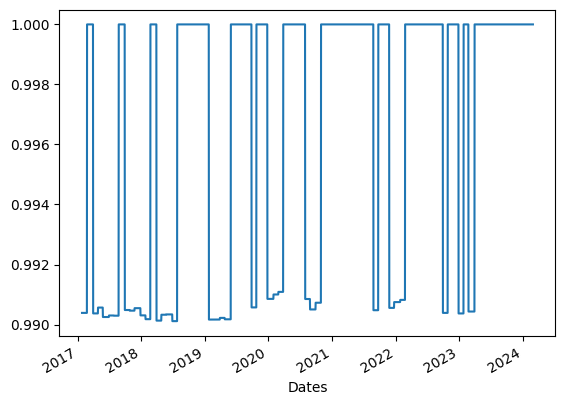

In [708]:
k200_daily_w.sum(1).plot()

<Axes: xlabel='Dates'>

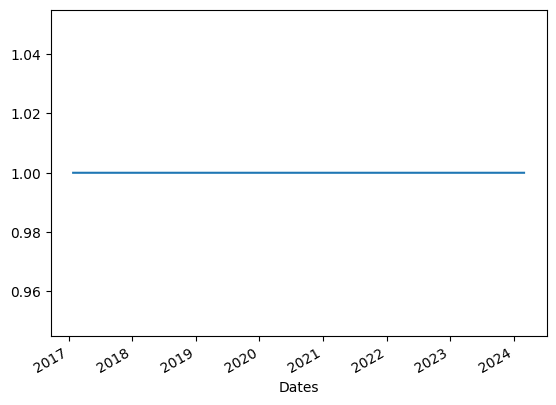

In [709]:
k200_daily_mkw.sum(1).plot()

In [710]:
k200_daily_w.columns

Index(['A005930', 'A012330', 'A051910', 'A097230', 'A005090', 'A001120',
       'A170900', 'A007210', 'A036580', 'A034120',
       ...
       'A280360', 'A003230', 'A175330', 'A139130', 'A001570', 'A005420',
       'A008730', 'A009970', 'A145720', 'A006110'],
      dtype='object', name='Symbol', length=275)

<Axes: xlabel='Dates'>

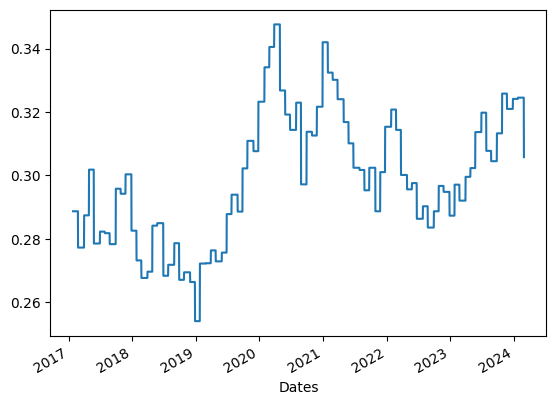

In [717]:
k200_daily_w['A005930'].plot()

<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

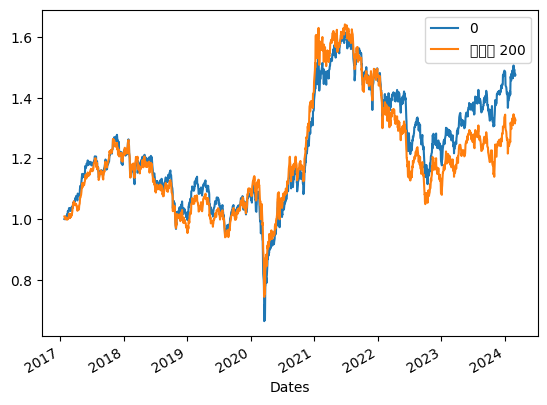

In [715]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_w.index, k200_daily_w.columns], 
                                                                        k200_daily_w.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index]).cumprod()], axis=1).plot()

In [703]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_w.index])

temp_perf200.T

/home/hyungshin.lee/post analysis/../py/performance.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = (1+final_return).cumprod()[-1] -1
/home/hyungshin.lee/post analysis/../py/performance.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = ((1+final_return).cumprod()[-1]**(base_date_period/(len(final_return))))-1 # geometric mean


,k200
cum return(%),-3.08
cagr(%),-0.45
vol(te),0.06
sharpe(ir),-0.08
mdd(%),-19.13
turnover(%),0
start date,2017-01-26 00:00:00
end date,2024-02-29 00:00:00


In [704]:
k200_daily_mkw

Symbol,A000080,A000810,A000990,A001060,A001120,A001680,A001740,A001780,A002270,A002960,...,A280360,A003230,A139130,A175330,A001570,A005420,A008730,A009970,A145720,A006110
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-26,0.007564,0.019264,0.007464,0.007364,0.007764,0.007364,0.007964,0.006964,0.007264,0.007064,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-31,0.007564,0.019264,0.007464,0.007364,0.007764,0.007364,0.007964,0.006964,0.007264,0.007064,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-01,0.007564,0.019264,0.007464,0.007364,0.007764,0.007364,0.007964,0.006964,0.007264,0.007064,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-02,0.007564,0.019264,0.007464,0.007364,0.007764,0.007364,0.007964,0.006964,0.007264,0.007064,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02-03,0.007564,0.019264,0.007464,0.007364,0.007764,0.007364,0.007964,0.006964,0.007264,0.007064,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.000000,0.000000,0.008497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.007997,0.008497,0.0,0.000000,0.007197,0.007297,0.007597,0.000000
2024-02-26,0.000000,0.000000,0.008497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.007997,0.008497,0.0,0.000000,0.007197,0.007297,0.007597,0.000000
2024-02-27,0.000000,0.000000,0.008497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.007997,0.008497,0.0,0.000000,0.007197,0.007297,0.007597,0.000000


<Axes: xlabel='Dates'>

/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarnin

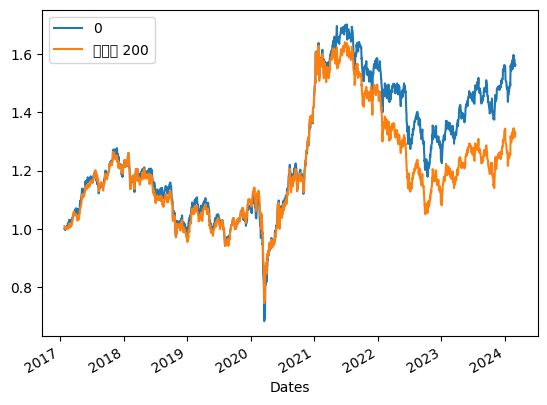

In [706]:
idx_ret, idx_ret_cost, idx_cum_ret, idx_cum_retcost = perf.return_index(adjprc.loc[k200_daily_mkw.index, 
                                                                                    k200_daily_mkw.columns], 
                                                                        k200_daily_mkw.shift(1),
                                                                        cost=0.00)
pd.concat([idx_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index]).cumprod()], axis=1).plot()

In [622]:
temp_perf200 = perf.analyze_performance(idx_ret_cost, 
                                     model_name = 'k200',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k200_daily_mkw.index])

temp_perf200.T

/home/hyungshin.lee/post analysis/../py/performance.py:315: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = (1+final_return).cumprod()[-1] -1
/home/hyungshin.lee/post analysis/../py/performance.py:317: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = ((1+final_return).cumprod()[-1]**(base_date_period/(len(final_return))))-1 # geometric mean


,k200
cum return(%),17.28
cagr(%),2.33
vol(te),0.05
sharpe(ir),0.52
mdd(%),-11.45
turnover(%),0
start date,2017-01-26 00:00:00
end date,2024-02-29 00:00:00


## k100 ew with samsung neutral

In [ ]:
top_prob_k100_unstack=top_prob_k100_df.unstack().copy()
top_prob_k100_unstack.columns=top_prob_k100_unstack.columns.get_level_values(1)

k100_weight_ls=[]
for date in rebal_dates:
    temp_top_prob=top_prob_k100_unstack.loc[date].copy()
    ew_sum=1-sam_w.loc[date, 'idx_weight'].values/100
    
    # if samsung is in the top then add additional weight to idx weight
    if 'A005930' in temp_top_prob.index:
        temp_ew=ew_sum/num_selection_k100
        temp_top_prob[temp_top_prob>0]=temp_ew[0]
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100+temp_ew[0]
    else:
        temp_ew=ew_sum/(num_selection_k100+1)
        temp_top_prob.loc['A005930']=sam_w.loc[date, 'idx_weight'].values/100
        
    k100_weight_ls.append(temp_top_prob)    
        

In [ ]:
k100_weight_df=pd.concat(k100_weight_ls, axis=1).T
temp_adj=adjprc.loc[k100_weight_df.index[0]:k100_weight_df.index[-1], k100_weight_df.columns].copy()
k100_daily_w=temp_adj.copy()
k100_daily_w.loc[k100_weight_df.index]=0
k100_daily_w[k100_daily_w!=0]=None
k100_daily_w.loc[k100_weight_df.index]=k100_weight_df.fillna(0)
k100_daily_w=k100_daily_w.fillna(method='ffill')

In [ ]:
k100_weight_df.count(1)

In [ ]:
k100_ret, k100_ret_cost, k100_cum_ret, k100_cum_retcost = perf.return_index(temp_adj, 
                                                                        k100_daily_w.shift(1),
                                                                        cost=0.003)

### 75 ew/ 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf75 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_75',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])



In [ ]:
temp_perf75.T

### 50 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf50 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_50',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf50

### 100 ew /100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf100 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_100',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])
temp_perf100

### 30 ew / 100

In [ ]:
pd.concat([k100_cum_retcost, (1+krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index]).cumprod()], axis=1).plot()

In [ ]:
temp_perf30 = perf.analyze_performance(k100_ret_cost, 
                                     model_name = 'k100_30',
                                     bm_return=krx_idx['코스피 200'].pct_change().loc[k100_daily_w.index])

temp_perf30

In [ ]:
pd.concat([temp_perf30, temp_perf50, temp_perf75, temp_perf100], axis=0).T

In [ ]:
sector in temp_sector_cap_prob['FG_Sector_Idx'].unique()

In [ ]:
temp_bm_sector=bm_sector.loc[date]
temp_bm_sector[temp_bm_sector['FG_Sector_Idx']==sector]

In [ ]:
temp_bm_sector.index

In [ ]:
missing_sector=temp_mktcap[temp_mktcap['FG_Sector_Idx']==sector].loc[date, 'MktCap']
missing_sector/missing_sector.sum()

In [ ]:
temp_mktcap.loc[date][temp_bm_sector.index]

In [ ]:
temp_bm_sector.index

In [ ]:
daily_sector_weight

In [ ]:
temp_sector_neutral

In [ ]:
cap_prob_df.index.get_level_values(0).unique()

In [ ]:
cap_prob_df[cap_prob_df.index.get_level_values(0)==date]